# Homework 1 (HW1)

---
By the end of this homework we expect you to be able to:
1. Load data from different formats using [pandas](https://pandas.pydata.org/);
2. Navigate the documentation of Python packages by yourself;
3. Filter and tidy up noisy data sets;
4. Aggregate your data in different (and hopefully helpful) ways;
5. Create meaningful visualizations to analyze the data;
6. Critically think and write about data;
---

## Important Dates

- Homework release: Fri 8 Oct 2021
- **Homework due**: Fri 22 Oct 2021, 23:59
- Grade release: Fri 29 Oct 2021

---

##  Some rules

1. You are allowed to use any built-in Python library that comes with Anaconda. If you want to use an external library,
you may do so, but must justify your choice.
2. Make sure you use the `data` folder provided in the repository in read-only mode. (Or alternatively, be sure you
don’t change any of the files.)
3. Be sure to provide a textual description of your thought process, the assumptions you made, the solution you
implemented, and explanations for your answers. A notebook that only has code cells will not suffice.
4. For questions containing the **/Discuss:/** prefix, answer not with code, but with a textual explanation
 (**in markdown**).
5. Back up any hypotheses and claims with data, since this is an important aspect of the course.
6. Please write all your comments in English, and use meaningful variable names in your code. Your repo should have a
single notebook (plus the required data files) in the *master/main* branch. If there are multiple notebooks present,
we will **not grade** anything.
7. We will **not run your notebook for you**! Rather, we will grade it as is, which means that only the results
contained in your evaluated code cells will be considered, and we will not see the results in unevaluated code cells.
Thus, be sure to hand in a **fully-run and evaluated notebook**. In order to check whether everything looks as intended,
 you can check the rendered notebook on the GitHub website once you have pushed your solution there.
8. In continuation to the previous point, interactive plots, such as those generated using `plotly`, should be
**strictly avoided**!
9. Make sure to print results or dataframes that confirm you have properly addressed the task.

---

## Context

In this project, we are going to analyze data from an experiment about *honesty*.
Oftentimes, we are asked to confirm our honest intentions by signing **at the end** of a document.
For example, in tax returns or insurance policy forms, we are often asked to sign our names under a text that reads
something like "I hereby certify that the above statements are true and correct to the best of my knowledge."

However, when individuals sign **after** lying in the form, they may not feel the need to correct the falsehoods they
have reported. In that context, it could be that signing at **the beginning** rather than at the end of the document
would decrease dishonesty, as those who are filling the form would be aware of the ethical requirements *before* they
provide the information in the form.

This intuition has led researchers to partner up with a motorcycle insurance company to run a randomized experiment.
In this insurance company (as well as in many others), customers had to report the exact *odometer kilometrage*¹ in
order for the company to adjust the insurance premiums. Note that motorcycles with lower kilometrage are less likely to
have issues, and thus will result in a lower *insurance premium*². Therefore, customers have an incentive to lie,
reporting a kilometrage lower than the real value, in order to save money.

In the experiment, two different forms were created: one where the signing was done at the end, and another where the
signing was done at the beginning. The insurance company then randomized these forms (i.e., each customer received
 exactly one form, each with probability 50%) and sent back the data that customers had provided. Some noteworthy
 details on the experiment are that:

- All customers involved in the experiment already had a contract with the company and were simply renewing it.
In the data that the company provided, they also report the odometer kilometrage for their previous contract.
Each policy, therefore, contains two contracts: the "updated" contract —where the experiment was conducted— and
the "baseline" contract, which was the previous contract customers had with the company.
- A single insurance policy can insure up to 4 distinct motorcycles.

In this assignment, you will take the role of the researcher and work analyzing this data!

*Glossary:*
1. **odometer kilometrage:** the total distance the motorcycle has traveled.
2. **insurance premiums:** the amount of money one pays for an insurance policy.

---

## The data

The company provided you with a compressed `.tsv` file containing one row per policy.
The `.tsv` has the following fields:

- `condition`: either `Sign Top` or `Sign Bottom`, depending on which form was sent.
- `id`: unique identifier for each insurance policy.
- `motorcycle_count`: number of motorcycles covered by the insurance policy.
- `baseline_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *previous (baseline)* contract.
- `update_motorcycle[1-4]`: odometer kilometrage *reported by the customer* in the *current (updated)* contract.

Some comments:

- Recall that a single policy can ensure up to 4 motorcycles, and thus, the suffixes [1-4] indicate that there are 4
versions of these columns in the data (e.g., `baseline_motorcycle1`, `baseline_motorcycle2`, `baseline_motorcycle3`,
`baseline_motorcycle4`).
- When a policy has fewer than 4 motorcycles, only the columns with the smaller numerals are filled (e.g., if a policy
insures one motorcycle,  only `baseline_motorcycle1` and `update_motorcycle1` will be filled).
- Note that we only have access to the odometer kilometrage reported by the customers,
which may be different from the real kilometrage of the motorcycles.

In [1]:
# Imports you may need
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
import seaborn as sns

# Supresses copy warnings
pd.options.mode.chained_assignment = None

### **Task 1** — 4pts

Your first task is to load the dataset into memory using pandas.
**You should load the data directly from the compressed files.**

Here, the files at hand are rather small, and you could easily uncompress the files to disk and work with them as plain
text. Why, then, are we asking you to load the files compressed? The reason is that, in your life as a data scientist,
this will often not be the case. Then, working with compressed files is key so that you don't receive email from your
(often more responsible) colleagues demanding to know how you have managed to fill the entire cluster with your
datasets. Another big advantage of compressing files is to simply read files faster. You will often find that reading
compressed data on the fly (uncompressing it as you go), is much faster than reading uncompressed data, since reading
and writing to disk may be your [bottleneck](https://skipperkongen.dk/2012/02/28/uncompressed-versus-compressed-read/).

---

**Hint:** `pandas` can open compressed files.

**Hint:** In the real world (and in ADA-homework), your file often comes with some weird lines!
This time you can safely ignore them (but in the real world you must try to understand why they are there!).
Check the `error_bad_lines` or the `on_bad_lines` (depending on your pandas version) parameter on `read_csv`.

In [2]:
insurance_ds = pd.read_csv("./data/data.tsv.gz", sep="\t", on_bad_lines="warn", compression="infer")

b'Skipping line 2142: expected 11 fields, saw 27\n'


### Task 2 — 12pts

As a good data scientist, the first thing you do is to clean up the data and perform some small sanity checks.

1. The motorcycle insurance company mentioned that each policy has a unique identifier, but that there may be duplicate
rows (i.e., multiple rows with the same policy identifier). Check if there are duplicate policies and, if so, filter
these rows from the data (always keeping the first).

2. According to the company, all policies should have kept the number of motorcycles from the previous contract (i.e.,
the number of motorcycles recorded in baseline contracts should equal the number of motorcycles in updated contracts).
Also, the number of odometer readings for each contract should be the same as the number stated in the
`motorcycle_count` variable. Check the data to see if these two things hold. If not, filter the anomalous rows.

3. Calculate the mean and the median value of each column related to kilometrages. Are the values obtained plausible?
Visualize the distribution of the data and remove any extreme outliers.

4. **Discuss:** In cases where you cannot think of appropriate ways to remove outliers, would you prefer summarizing
numerical data with outliers with the mean or the median? Why?

---

**Hint:** Here we are considering as outliers numbers that are not plausible in the context of motorcycle kilometrages.

2.1. Check if there are duplicate rows, filter if exists

In [3]:
# IDs are not unique
print("IDs are unique!" if insurance_ds.id.is_unique else "IDs are NOT unique!")
duplicated_ids = insurance_ds[insurance_ds.id.duplicated()].id
print(f"There are {len(duplicated_ids)} duplicates, some of which are:")
insurance_ds[insurance_ds.id.isin(duplicated_ids)].head(10)

IDs are NOT unique!
There are 9 duplicates, some of which are:


,condition,id,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count
13,Sign Bottom,14,83443,105094,NaN,NaN,NaN,NaN,NaN,NaN,1
14,Sign Bottom,14,83443,105094,NaN,NaN,NaN,NaN,NaN,NaN,1
332,Sign Bottom,332,1721,30093,30482.0,38315.0,NaN,NaN,NaN,NaN,2
333,Sign Bottom,332,1721,30093,30482.0,38315.0,NaN,NaN,NaN,NaN,2
750,Sign Top,749,101625,148134,135926.0,164660.0,NaN,NaN,NaN,NaN,2
751,Sign Top,749,101625,148134,135926.0,164660.0,NaN,NaN,NaN,NaN,2
1106,Sign Bottom,1104,114740,146569,NaN,NaN,NaN,NaN,NaN,NaN,1
1107,Sign Bottom,1104,114740,146569,NaN,NaN,NaN,NaN,NaN,NaN,1
1379,Sign Bottom,1376,46097,95235,NaN,NaN,NaN,NaN,NaN,NaN,1
1380,Sign Bottom,1376,46097,95235,NaN,NaN,NaN,NaN,NaN,NaN,1


In [4]:
# Filter non-unique policy IDs
# Create a backup in case we ever need the original dataset
orig_insurance_ds = insurance_ds.copy()
print("Dropping duplicate IDs...")
insurance_ds = insurance_ds.drop_duplicates(subset=["id"], keep="first")
print("IDs are unique!" if insurance_ds.id.is_unique else "IDs are NOT unique!")
insurance_ds[insurance_ds.id.isin(duplicated_ids)].head(10)

Dropping duplicate IDs...
IDs are unique!


,condition,id,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count
13,Sign Bottom,14,83443,105094,NaN,NaN,NaN,NaN,NaN,NaN,1
332,Sign Bottom,332,1721,30093,30482.0,38315.0,NaN,NaN,NaN,NaN,2
750,Sign Top,749,101625,148134,135926.0,164660.0,NaN,NaN,NaN,NaN,2
1106,Sign Bottom,1104,114740,146569,NaN,NaN,NaN,NaN,NaN,NaN,1
1379,Sign Bottom,1376,46097,95235,NaN,NaN,NaN,NaN,NaN,NaN,1
1535,Sign Bottom,1531,72973,116284,NaN,NaN,NaN,NaN,NaN,NaN,1
1779,Sign Top,1774,21000,70058,NaN,NaN,NaN,NaN,NaN,NaN,1
2142,Sign Bottom,2136,13061,25046,NaN,NaN,NaN,NaN,NaN,NaN,1
13228,Sign Bottom,13451,9999999999999999999,1623780,62221.0,99143.0,NaN,NaN,NaN,NaN,2


In [5]:
# Reindex the DS according to policy IDs
"""
This is not necessary, however convenient
It replaces pandas generated indices with policy IDs
"""
insurance_ds = insurance_ds.set_index(["id"], verify_integrity=True)
insurance_ds.head()

,condition,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count
id,,,,,,,,,,
1,Sign Top,896,39198,NaN,NaN,NaN,NaN,NaN,NaN,1
2,Sign Bottom,21396,63511,32659.0,47605.0,NaN,NaN,NaN,NaN,2
3,Sign Bottom,21340,37460,44998.0,59002.0,NaN,NaN,NaN,NaN,2
4,Sign Bottom,23912,59136,NaN,NaN,NaN,NaN,NaN,NaN,1
5,Sign Bottom,16862,59292,NaN,NaN,NaN,NaN,NaN,NaN,1


2.2 Check conditions of the company
- \# baseline $==$ \# updated
- \# of odometer readings $==$ motorcycle count
- baseline_motorcycle($n$) can exist iff all the previous baselines exist where $n\in \{2, 3, 4\}$

Check if baseline and update of a motorcycle are either both NaN or both numerical values by XOR. If the result of the XOR operation is 1 (`True`) then either one of the baseline or the update values for a motorcycle is missing. By summing the output of the XOR operation, we can check if any of the values is `True`.

In [6]:
baseline_update_check = pd.DataFrame({
    f"m{i}": insurance_ds[f"baseline_motorcycle{i}"].isna() ^ insurance_ds[f"update_motorcycle{i}"].isna()
    for i in range(1, 4 + 1)
})

# Sum all the outputs of XOR and check if a True value exists
print(
    "No baseline/update mismatches" if baseline_update_check.sum().sum() == 0 else "There exist baseline/update mismatches")

No baseline/update mismatches



Now that we know there are no baseline/update mismatches, we can check either baseline or update values of a policy for motorcycle count.

By summing the number of NaNs in a policy's baseline we can calculate the number of motorcycles it has and compare it with the value in the `motorcycle_count` column


In [7]:
marginal_count = 4 - insurance_ds[[f"baseline_motorcycle{i}" for i in range(1, 4 + 1)]].isna().sum(axis=1)
reported_count = insurance_ds["motorcycle_count"]
match = (marginal_count == reported_count).all()

print(f"Number of odometer readings{'' if match else ' do not'} match the number of motorcycles")

Number of odometer readings match the number of motorcycles


Finally, check the third condition stating that all previous baselines must exist

In [8]:
def umi(i):
    return f"update_motorcycle{i}"


def bmi(i):
    return f"baseline_motorcycle{i}"


def nan_before_value(row):
    nan_before_value_at_position = lambda pos: pd.isna(row[bmi(pos)]) and not pd.isna(row[bmi(pos + 1)])
    nan_was_before = [nan_before_value_at_position(i) for i in [1, 2, 3]]
    return True in nan_was_before


nan_before_value_rows = insurance_ds[insurance_ds.apply(nan_before_value, axis=1)]
nan_before_value_rows[[bmi(i) for i in range(1, 4 + 1)] + ["motorcycle_count"]]

,baseline_motorcycle1,baseline_motorcycle2,baseline_motorcycle3,baseline_motorcycle4,motorcycle_count
id,,,,,
23,78182,21730.0,NaN,118250.0,3
64,78704,NaN,17406.0,NaN,2
71,194677,NaN,NaN,2827.0,2
78,15643,NaN,168238.0,NaN,2
97,101658,38662.0,NaN,119860.0,3
...,...,...,...,...,...
13466,151600,113100.0,NaN,57237.0,3
13473,121024,NaN,NaN,4000.0,2
13478,100467,NaN,20.0,NaN,2


There are $890$ rows where a missing motorcycle number comes before one that exists, as shown in the table above. As we have no reason to believe that these rows have data inconsistencies introduced (besides being malformed), we decide to leave the rows as they are as not removing them should not affect the correctness of the remaining analysis.

2.3. Calculating the mean and the median value of each column related to kilometrages

In [9]:
# Calculate the mean, median values, append in Pandas Series and print
mean_df = pd.DataFrame({
    f"{contract}_m{i}": insurance_ds[f"{contract}_motorcycle{i}"].mean()
    for contract in ["baseline", "update"]
    for i in range(1, 4 + 1)
}, index=["mean"])
median_df = pd.DataFrame({
    f"{contract}_m{i}": insurance_ds[f"{contract}_motorcycle{i}"].median()
    for contract in ["baseline", "update"]
    for i in range(1, 4 + 1)
}, index=["median"])

mean_median_df = pd.concat([mean_df, median_df], axis=0)
print(f"Mean and Median of Baseline (b) and Update (u) of Motorcycles\n\n")
mean_median_df

Mean and Median of Baseline (b) and Update (u) of Motorcycles




,baseline_m1,baseline_m2,baseline_m3,baseline_m4,update_m1,update_m2,update_m3,update_m4
mean,7.413998e+14,67325.967422,67657.320282,67827.97546,7.413998e+14,92277.633144,92849.408771,93374.279141
median,5.634150e+04,56157.500000,58821.000000,68181.00000,8.239750e+04,82061.000000,85645.000000,93387.500000


From the output above, something seems to be wrong with the reports for baseline and update contracts of the first motorcycle. An average of $7.4 \times 10^{14}$ kilometers is equal to the distance the light can travel in 78 years ($300000*3600*24*365*78=7.4 \times 10^{14}$). Remember that we are about $4.4$ light-years away from our closest neighbouring star, *Proxima Centauri*, so this is a little suspicious.

Let's find the outlier(s):

Motorcycle 1 contracts -- maximum value seen: 9999999999999999999
Motorcycle 2 contracts -- maximum value seen: 1030915
Motorcycle 3 contracts -- maximum value seen: 931105
Motorcycle 4 contracts -- maximum value seen: 244658


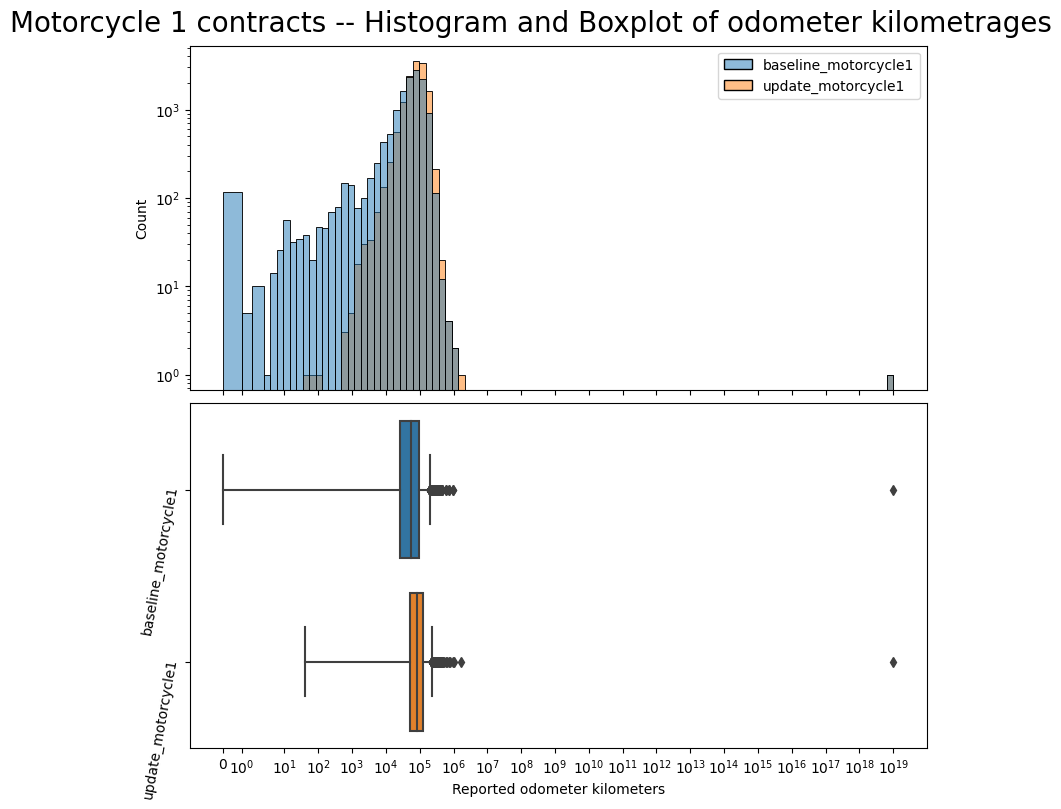

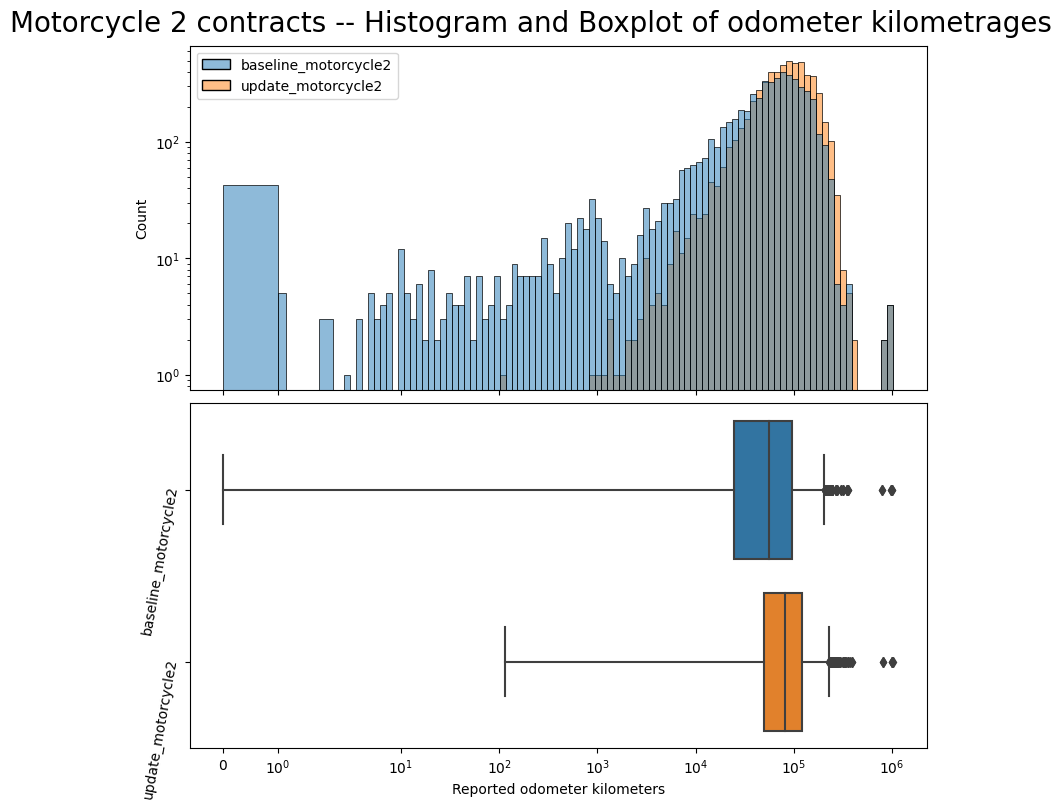

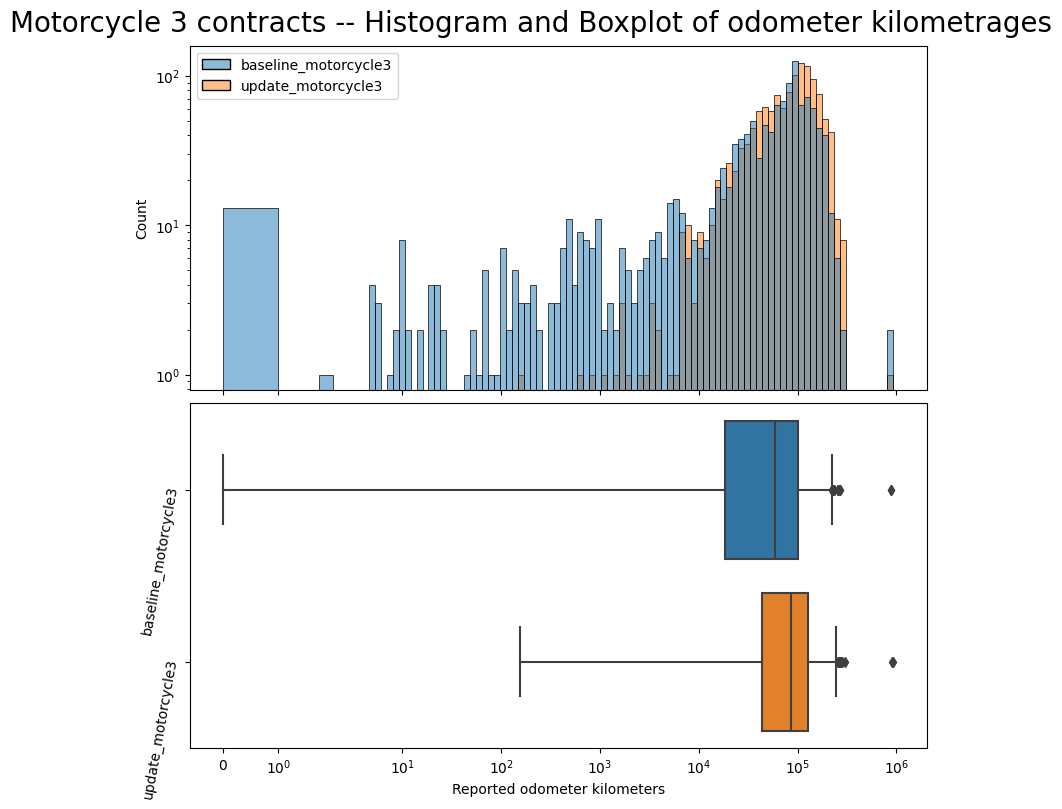

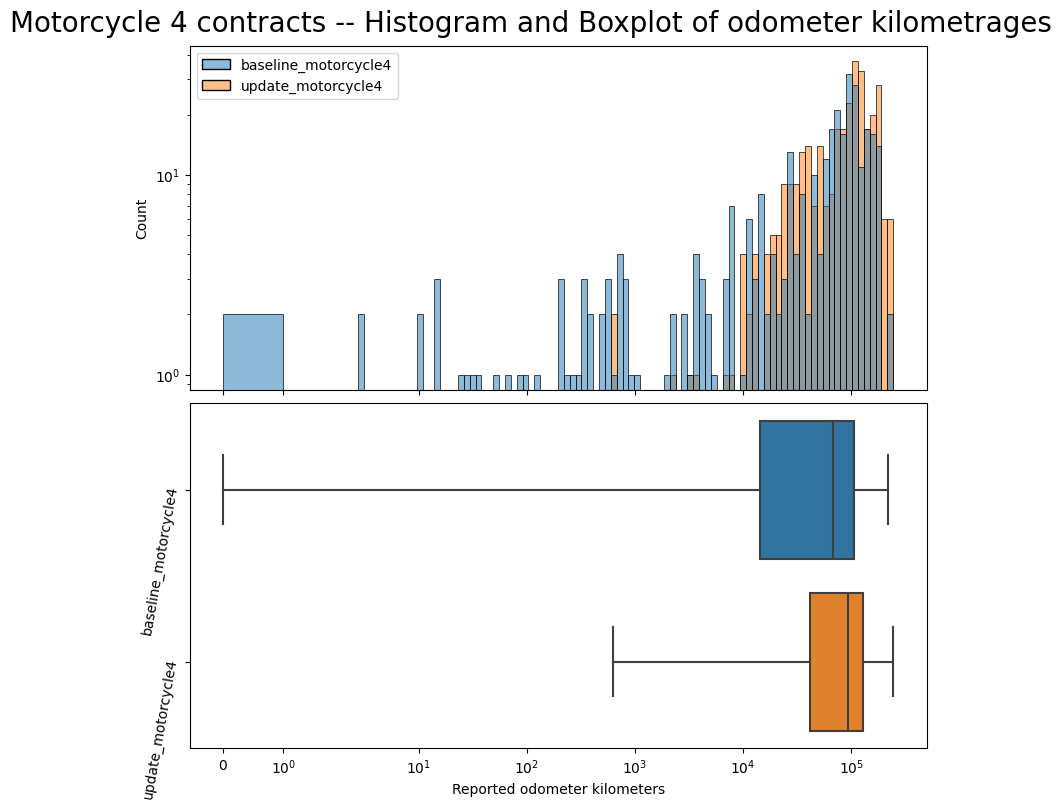

In [10]:
# Plot the outliers
def plot_contracts_distributions(whis=np.inf):
    for i in range(1, 4 + 1):
        fig, axs = plt.subplots(2, 1, figsize=(8, 8), dpi=100, sharex="all", sharey="row", constrained_layout=True)
        fig.suptitle(f"Motorcycle {i} contracts -- Histogram and Boxplot of odometer kilometrages", fontsize=20)
        contract_columns = insurance_ds[[f"baseline_motorcycle{i}", f"update_motorcycle{i}"]]

        hist_axis = axs[0]
        hist_axis.set_xscale("symlog")
        hist_axis.set_yscale("log")
        # hist_axis.set_title("Distribution of reported odometer kilometrage")

        box_axis = axs[1]
        box_axis.set_xlabel("Reported odometer kilometers")
        # box_axis.set_title("Box plot of reported odometer kilometrage")

        max_kilometrage = contract_columns.max().max()
        print(f"Motorcycle {i} contracts -- maximum value seen: {int(max_kilometrage)}")
        bins = np.concatenate([np.array([0]), np.logspace(0, np.log10(max_kilometrage), 100)])
        sns.histplot(data=contract_columns, bins=bins, ax=hist_axis)
        sns.boxplot(data=contract_columns, orient="h", ax=box_axis, whis=whis)
        plt.yticks(rotation=80)


plot_contracts_distributions(whis=1.5) # 1.5 corresponds to Tukey's original definition of boxplots

The outliers can be clearly observed in the distribution plots and boxplots given above as the two points on the far right of motorcycle 1 contracts. Besides the enormous values that these outliers achieve, their presence could also have been suspected in the large difference between the mean and median values that are too far apart (aka have a huge gap in between).

To eliminate these outliers, we can calculate the $Z$-scores (standard scores) of the two columns and eliminate values that are above the threshold $1$.

In [11]:
z_scores = np.abs(stats.zscore(insurance_ds[["baseline_motorcycle1", "update_motorcycle1"]]))
filtered_policies = (z_scores < 1).all(axis=1)
print("Removed Outliers\n")
insurance_ds.iloc[np.where(z_scores > 1)[0]]

Removed Outliers



,condition,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count
id,,,,,,,,,,
8888888,Sign Bottom,36112,9999999999999999999,NaN,NaN,NaN,NaN,NaN,NaN,1
13451,Sign Bottom,9999999999999999999,1623780,62221.0,99143.0,NaN,NaN,NaN,NaN,2


In [12]:
# Remove the outliers using the mask
insurance_ds = insurance_ds[filtered_policies]

Motorcycle 1 contracts -- maximum value seen: 1010893
Motorcycle 2 contracts -- maximum value seen: 1030915
Motorcycle 3 contracts -- maximum value seen: 931105
Motorcycle 4 contracts -- maximum value seen: 244658


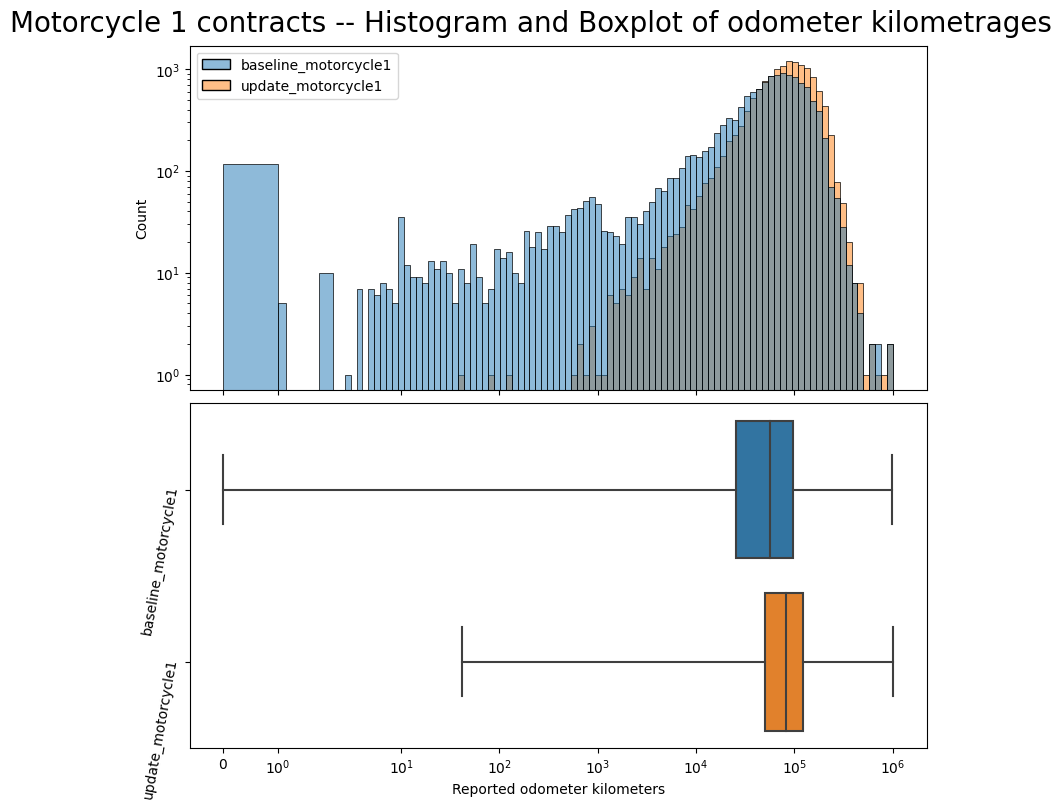

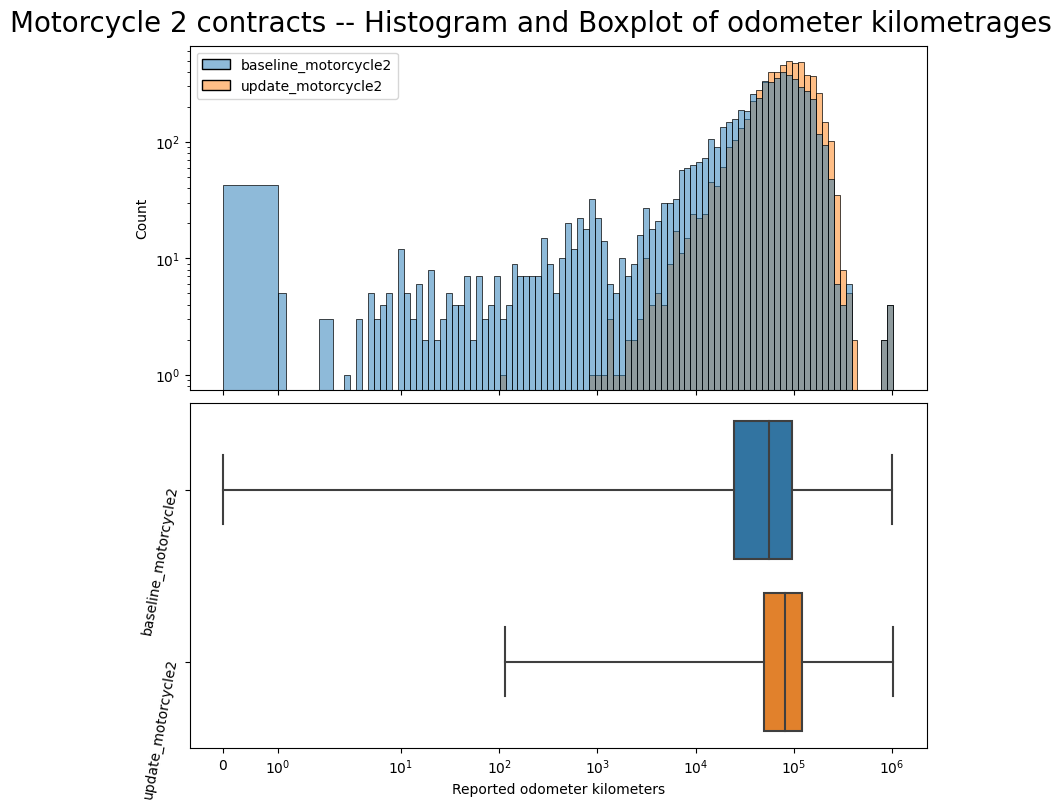

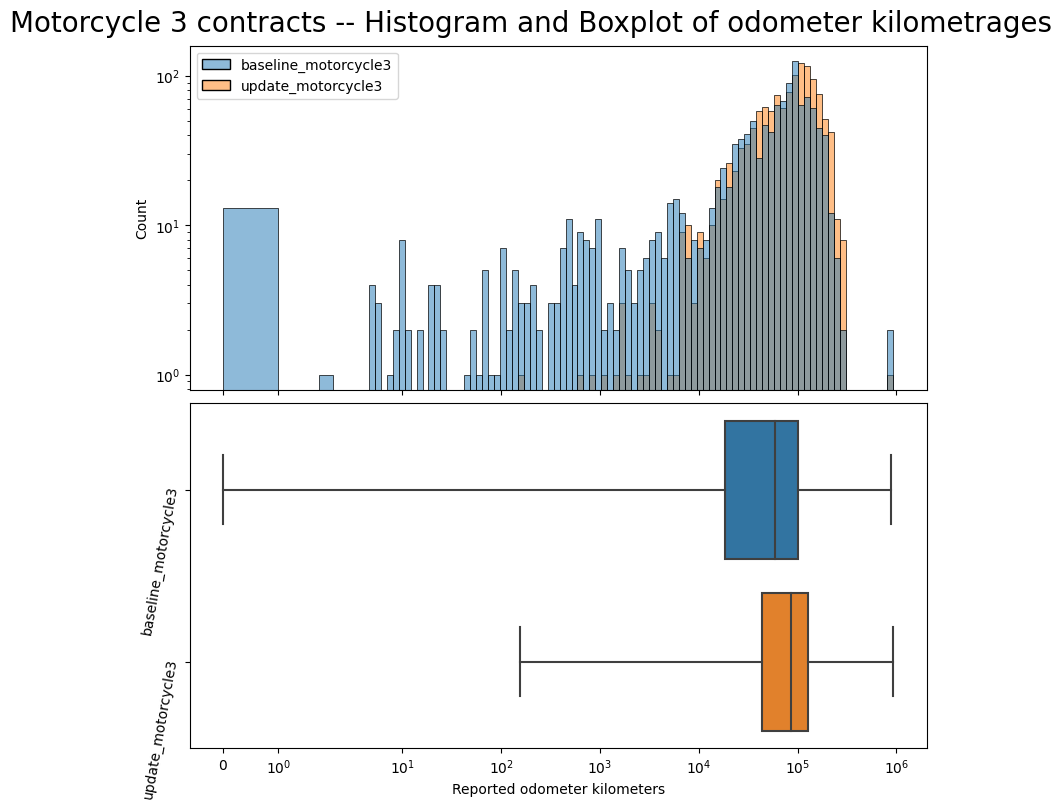

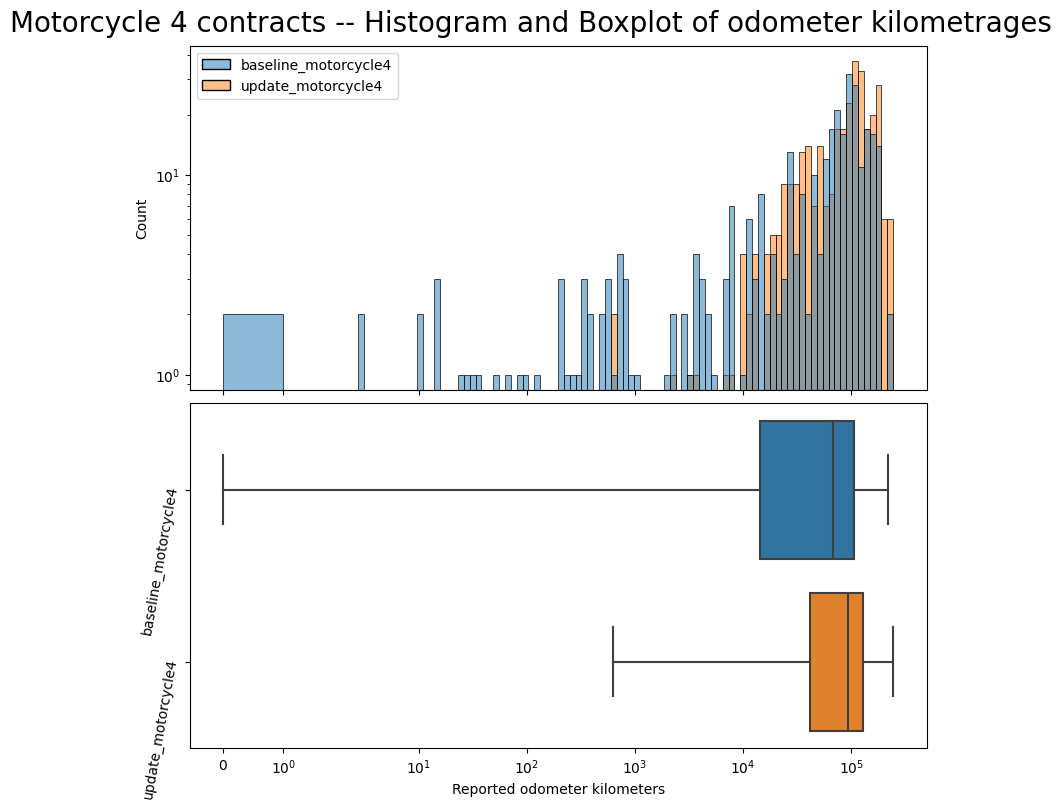

In [13]:
# Plot the values
plot_contracts_distributions(whis=np.inf)

Now that the outliers are removed, kilometrage values seem more reasonable. Even though some might argue that a motorcycle with over 1 million kilometers on the odometer is quite far-fetched, we don't remove them from the dataset since they are unlikely to be wrong entries.

Moreover, to correctly visualize the **non-outlier** values present in the dataset, the whiskers of the box plots are increased to capture all data since we consider the outliers to be already removed.

2.4. Discussion

In cases where the outliers can not be removed or handled properly, using the median over the mean would and should be preferred. It's simply because the median is more robust to outliers than the mean. Since the outliers don't have a great impact on it, the median gives a better, more reliable summary of numerical data.

### Task 3 — 12pts

One of the challenges with the current data is that it is not clear how to handle policies with multiple motorcycles.

1. Create three additional columns in the dataframe, `baseline_average`, `update_average`, and `diff_average`. These
should contain, respectively, the average value for `baseline_motorcycle[1-4]` for all motorcycles insured; the average
 value for `update_motorcycle[1-4]`; and the difference between the average updated value and the average baseline
 value.
2. **Discuss:** Propose another way of aggregating distinct motorcycles from a single policy. Point out a way in which
this aggregation may be either better or worse than taking the average for the purpose of comparing the two scenarios in
 the study (sign at the top vs. sign at the bottom).
3. To get a sense of the impact that policies with multiple motorcycles may have in the study, let's perform some
additional analyses. Plot the distribution of motorcycles per policy in the data. Your plot should allow for the
meaningful comparison of the values shown.
4. In 3.1, you calculated the average kilometrage for each policy for the updated contract. Calculate the mean and the
standard deviation of these values (which should be in the column `update_average`).
5. Another meaningful metric is the average kilometrage **per motorcycle**, not distinguishing motorcycles in different
policies (i.e., pooled across policies). **Considering only policies with 4 motorcycles insured,** calculate the mean
and the standard deviation of the kilometrage per motorcycle in the updated contract.
6. **Discuss:** To analyze whether signing at the top decreases dishonesty, we could consider the data in different
ways. We could first calculate the average value per motorcycle within each policy and have one data point per policy
**or** we could analyze the data at the motorcycle level and have one data point per motorcycle in the dataset.
According to questions 3.4 and 3.5, how may this decision influence the results of the study?
---

3.1. Create additional columns

Key assumption: If a policy is missing (NaN) a baseline or update value, this means that the policy is not assigned with a corresponding value and therefore the missing value is not considered during calculations. E.g. a policy having only two baseline values, `baseline_motorcycle1` and `baseline_motorcycle2` will have a `baseline_average` calculated as follows:

$\text{baseline\_average} = \frac{\text{baseline\_motorcycle1} + \text{baseline\_motorcycle2}}{2}$

In [14]:
# Create three new colums
insurance_ds["baseline_average"] = insurance_ds[
    ["baseline_motorcycle1", "baseline_motorcycle2", "baseline_motorcycle3", "baseline_motorcycle4"]].mean(axis=1)
insurance_ds["update_average"] = insurance_ds[
    ["update_motorcycle1", "update_motorcycle2", "update_motorcycle3", "update_motorcycle4"]].mean(axis=1)
insurance_ds["diff_average"] = insurance_ds["update_average"] - insurance_ds["baseline_average"]

# Print the new dataframe
insurance_ds.head()

,condition,baseline_motorcycle1,update_motorcycle1,baseline_motorcycle2,update_motorcycle2,baseline_motorcycle3,update_motorcycle3,baseline_motorcycle4,update_motorcycle4,motorcycle_count,baseline_average,update_average,diff_average
id,,,,,,,,,,,,,
1,Sign Top,896,39198,NaN,NaN,NaN,NaN,NaN,NaN,1,896.0,39198.0,38302.0
2,Sign Bottom,21396,63511,32659.0,47605.0,NaN,NaN,NaN,NaN,2,27027.5,55558.0,28530.5
3,Sign Bottom,21340,37460,44998.0,59002.0,NaN,NaN,NaN,NaN,2,33169.0,48231.0,15062.0
4,Sign Bottom,23912,59136,NaN,NaN,NaN,NaN,NaN,NaN,1,23912.0,59136.0,35224.0
5,Sign Bottom,16862,59292,NaN,NaN,NaN,NaN,NaN,NaN,1,16862.0,59292.0,42430.0


3.2. Discussion

Alternative to taking the average, another aggregation function that could be used to aggregate distinct motorcycles from a single policy could be summation. However, using summation as the aggregation function would be worse for the purpose of comparing the two scenarios in the study. Since the number of motorcycles in a policy differ, the sum value is expected to be higher for the policies with more motorcycles and lower for the policies with fewer motorcycles. In turn, this will cause a problem for the comparison between policy types with a different number of motorcycles.

3.3. Plotting the distribution of **the number** of motorcycles per policy in the data

No handles with labels found to put in legend.


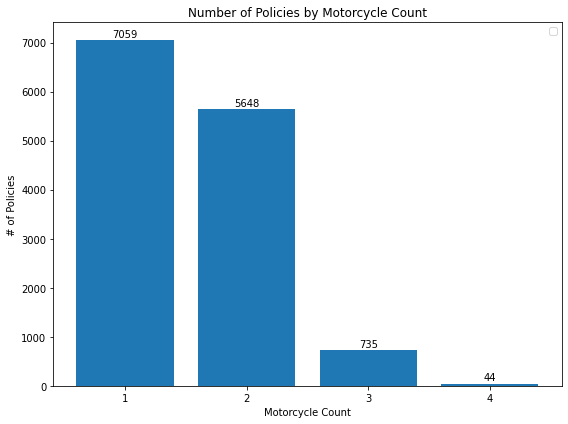

In [15]:
fig, ax = plt.subplots(figsize=(8, 6))
labels = insurance_ds.motorcycle_count.unique()
xs = np.arange(len(labels))
w = 0.8  # Width of bars

insurance_ds_bars = ax.bar(xs, insurance_ds.groupby(["motorcycle_count"])["condition"].count().values, width=w)
ax.set_ylabel("# of Policies")
ax.set_xlabel("Motorcycle Count")
ax.set_title("Number of Policies by Motorcycle Count")
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(insurance_ds_bars, padding=1)

fig.tight_layout()
plt.show()

The plot above shows the distribution of the number of motorcycles per policy. We can clearly see that policies with one and two motorcycles dominate the dataset. Let's also check if the types of policies (top signed and bottom signed) are evenly distributed or not.

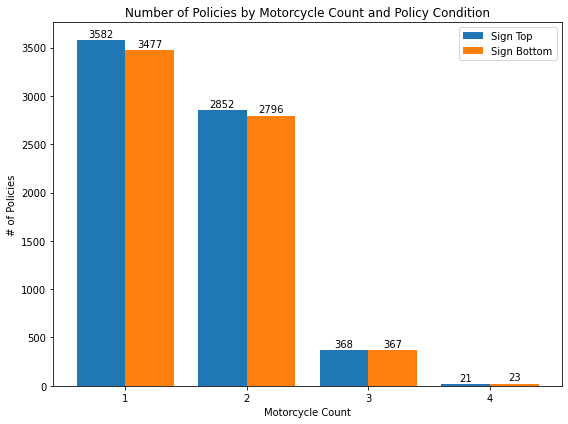

In [16]:
# Group policies (pivot or groupby would've worked just as well)
sign_top = insurance_ds.loc[insurance_ds["condition"] == "Sign Top"]
sign_bot = insurance_ds.loc[insurance_ds["condition"] == "Sign Bottom"]

fig, ax = plt.subplots(figsize=(8, 6))
labels = insurance_ds.motorcycle_count.unique()
xs = np.arange(len(labels))
w = 0.4  # Width of bars

top_bars = ax.bar(xs - w / 2, sign_top.groupby(["motorcycle_count"])["condition"].count().values, width=w,
                  label='Sign Top')
bot_bars = ax.bar(xs + w / 2, sign_bot.groupby(["motorcycle_count"])["condition"].count().values, width=w,
                  label='Sign Bottom')

ax.set_ylabel("# of Policies")
ax.set_xlabel("Motorcycle Count")
ax.set_title("Number of Policies by Motorcycle Count and Policy Condition")
ax.set_xticks(xs)
ax.set_xticklabels(labels)
ax.legend()

ax.bar_label(top_bars, padding=1)
ax.bar_label(bot_bars, padding=1)

fig.tight_layout()
plt.show()

Judging by the bar plot above, it's clear that top and bottom signed policies are evenly distributed and there is not a drastic imbalance.

3.4. Calculate mean and std of average update kilometrage

In [17]:
mean, std = insurance_ds["update_average"].mean(axis=0), insurance_ds["update_average"].std(axis=0)
pd.DataFrame([mean, std], columns=["Kilometrage"], index=["mean", "std"])

,Kilometrage
mean,92166.980090
std,52212.864277


3.5. Average kilometrage per motorcycle of policies with 4 motorcycles

In [18]:
policies_w_four_motorcycles = insurance_ds.loc[insurance_ds["motorcycle_count"] == 4]
all_motorcycles_from_p_w_four = pd.concat([policies_w_four_motorcycles[f"update_motorcycle{i}"] for i in range(1, 4 + 1)])

print("Mean and STD of Kilometrage per Motorcycle (Pooled Across Motorcycles)")
pd.DataFrame([all_motorcycles_from_p_w_four.mean(), all_motorcycles_from_p_w_four.std()], columns=["Kilometrage"], index=["mean", "std"])

Mean and STD of Kilometrage per Motorcycle (Pooled Across Motorcycles)


,Kilometrage
mean,113443.863636
std,83148.461506


To better compare the effects of calculating the average value per motorcycle within each policy and analyzing the data at the motorcycle level by having one data point per motorcycle in the dataset, the subset of policies with four motorcycles should be considered (apples to apples) as well.

In [19]:
mean_pw_four_motorcycles_over_policies = policies_w_four_motorcycles["update_average"].mean(axis=0)
std_pw_four_motorcycles_over_policies = policies_w_four_motorcycles["update_average"].std(axis=0)

print("Mean and STD of Kilometrage per Motorcycle (Pooled Across Policies)")
pd.DataFrame([mean_pw_four_motorcycles_over_policies, std_pw_four_motorcycles_over_policies], columns=["Kilometrage"],
             index=["mean", "std"])

Mean and STD of Kilometrage per Motorcycle (Pooled Across Policies)


,Kilometrage
mean,113443.863636
std,52853.832727


3.6. Discussion

To analyse whether signing at the top decreases dishonesty, we could consider the data in two different ways: as per-policy-average datapoints or as per-motorcycle dataopoints. Even though these two approaches look similar and will result in the same mean value, their datapoints will not follow the same distribution. We have checked this in task 3.6 by noticing significantly different in variance estimates when comparing the data for four motorcycle policies. We observed that the per-motorcycle datapoints had a much higher variance, but whether the variance wil be higher or lower in one case compared to the other is not predictable in general (which is trivial to prove).

The subtle but important difference between these two ways is that using per-motorcycle datapoints breaks one of the assumptions that might be useful in later analysis -- independence. The reported odometer values in the same policy have been made by the same customer and could reasonably be expected to highly correlate -- if the customer had lied for one motorcycle he owns, he might be prone to do it for the other ones as well! The choice of per-motorcycle datapoints would thus break the desirable independence assumption, making an argument for preferring per-policy average datapoints.

Notice, however, that the policies themselves might not be independent as well -- it might be the case that Gary and Joe both filled their forms, but are friends who decided to both report kilometrages that are higher/lower than they really are. Knowing something about Joe in this case would change the kilometrage distribution for Gary (aka the conditional distribution is different). This is a source of correlation we cannot eliminate now and it was not stated in the dataset description that they were independent. Nevertheless, the introduction of per-motorcycle datapoints could introduce even more correlation and the argument for preffering per-policy average datapoints is sound.

### Task 4 — 18pts

Now that we have compressed the kilometrage reported in each contract into a single number, it is time to analyze the
million-dollar question: *does signing at the top decrease dishonesty?*

1. Considering the updated contracts, calculate the mean and the standard deviation of the average kilometrage in a)
policies where the signing was done at the bottom; and b) policies where the signing was done at the top. Additionally,
plot the two kilometrage distributions.
2. Determine whether the difference between the two scenarios mentioned in 1. is statistically significant.
3. **Discuss:** Recall that the assignment of the different contracts (*sign at the top* vs. *sign at the bottom*) was
done at random. According to the results in 1. and 2., does signing at the top decrease dishonesty?
4.  **Discuss:** Given that no intervention was performed in the baseline contract (i.e., everyone signed at the
bottom). Would you expect any differences between the average values between *sign at the top* vs. *sign at the bottom*
 conditions for the baseline contract? Note that this is related to columns `baseline_motorcycle[1-4]`.
5. Calculate the mean and the standard deviation for the baseline contracts of the two groups (sign at the top vs. sign
at the bottom). Additionally, plot the two kilometrage distributions.
6. Determine whether the difference between the two scenarios mentioned in 5. is statistically significant.

---

**Hint:** Recall that the column `condition` encodes the experimental condition in which the customer fell when
reporting the values shown in columns `update_motorcycle[1-4]`!

**Hint:** To determine if the means of two sets of data are significantly different from each other, you may want to use
 the `ttest_ind` function implemented in the
 [scipy library](https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.ttest_ind.html). To learn more about
 Student's t-test, check out this [Wikipedia page](https://en.wikipedia.org/wiki/Student%27s_t-test).

#### 4.1. Calculate the mean and standard deviation of average update kilometrage per condition

In [20]:
mean_sign_bot_update_average = sign_bot["update_average"].mean(axis=0)
std_sign_bot_update_average = sign_bot["update_average"].std(axis=0)

mean_sign_top_update_average = sign_top["update_average"].mean(axis=0)
std_sign_top_update_average = sign_top["update_average"].std(axis=0)

print("Mean and STD of Update Average Kilometrage per contract type")
pd.DataFrame([[mean_sign_bot_update_average, mean_sign_top_update_average],
              [std_sign_bot_update_average, std_sign_top_update_average]],
              columns=["Sign Bot (Kilometrage)", "Sign Top (Kilometrage)"],
             index=["mean", "std"])

Mean and STD of Update Average Kilometrage per contract type


,Sign Bot (Kilometrage),Sign Top (Kilometrage)
mean,98692.362262,85794.618753
std,51928.181550,51704.289078


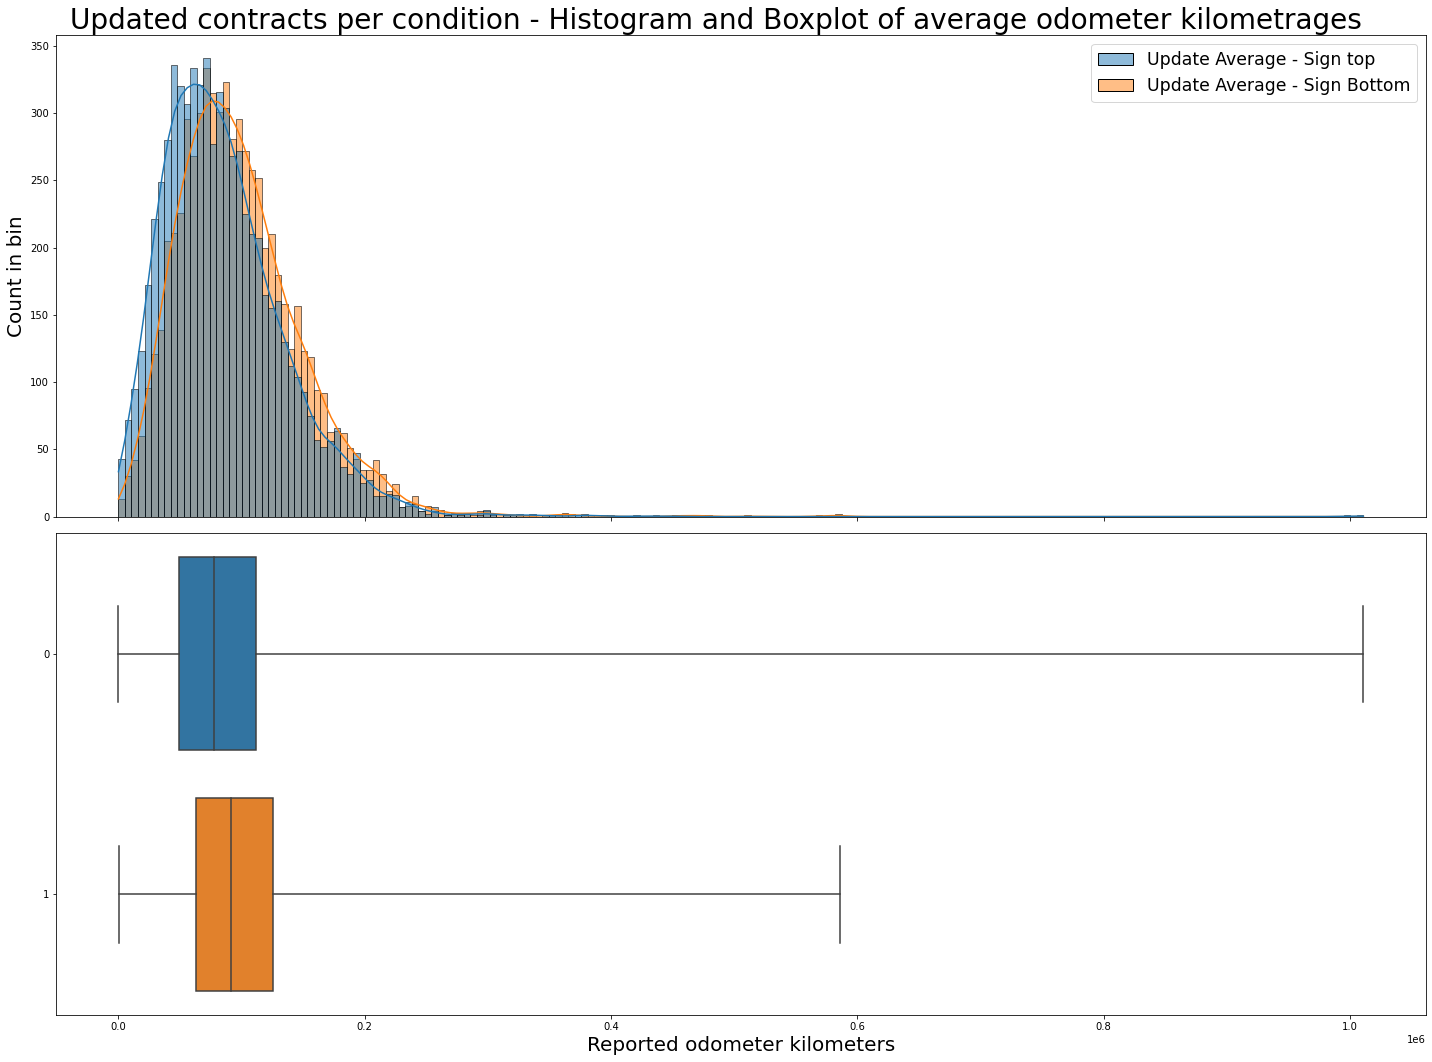

In [21]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex="col")

fig.suptitle(f"Updated contracts per condition - Histogram and Boxplot of average odometer kilometrages", fontsize=28)

sns.histplot({"Update Average - Sign top":sign_top["update_average"],
              "Update Average - Sign Bottom": sign_bot["update_average"]}, kde=True, ax=axs[0])
sns.move_legend(axs[0], "upper right", fontsize="xx-large")

sns.boxplot(data=[sign_top["update_average"].to_numpy(),
                  sign_bot["update_average"].to_numpy()], orient="h", ax=axs[1], whis=np.inf)

axs[0].set_ylabel("Count in bin", fontsize=20)
axs[1].set_xlabel("Reported odometer kilometers", fontsize=20)
fig.tight_layout()

The end of boxplot whiskers represents the minimum and maximum data point, while boxplots show quartiles of distributions.

#### 4.2. Test if there is significant difference between top or bottom signed update documents

We want to find out if signing at the top of the document or the bottom of the document affects the honesty of the insured. We will therefore compare the distributions of average kilometrage on renewed contracts signed at the beginning and end. For this, we will use the two-sample t-test to compare the mean values of the distributions.

One of the assumptions of the two-sample t-test is that distributions come from a normal distribution, but the t-test has proven to be a robust statistic when the number of samples is very large, so we will use it even though our distribution is not normally distributed. Also, the assumption of independent data is required to perform the t-test which does not necessarily hold for our dataset, as discussed in task 3.6. We will, however, **assume** the independence to be true, as it seems to be a reasonable assumption and is often done in surveys. As a further test requirement, the two-sample t-test variance of the distributions should be equal, but this assumption has as well been proved to be robust for a large number of samples.

We will therefore use the two-sample t-test to test the hypothesis, with a significance level of ($\alpha$) = 0.001.
##### Hypothesis:
\begin{equation}
H_0 = \text{The arithmetic means of average update kilometrage for bottom signed and top signed contracts are the same: } \mu_{\text{Sign bottom}} = \mu_{\text{Sign top}}
\\
H_a= \text{The arithmetic means of average update kilometrage for bottom signed contracts is lower compared to top signed:  } \mu_{\text{Sign bottom}} > \mu_{\text{Sign top}}
\end{equation}

In [22]:
t_test_update_average = stats.ttest_ind(sign_bot["update_average"], sign_top["update_average"], alternative="greater")

pd.DataFrame(data=[t_test_update_average.statistic, t_test_update_average.pvalue],
             columns=["Two-sample t-test"], index=["t statistic", "p-value"])

,Two-sample t-test
t statistic,1.445237e+01
p-value,2.717676e-47


There was a significant difference between the means of updated policies signed at the bottom (M=9869; SD=51928) and those that are signed at the top (M=85794; SD=51704), t(45448164) = 14.4524, p<<0.001. With this, we have strong evidence to reject the null hypothesis in favour of the bottom signed mean being greater than the top signed one. This, contrary to what the company speculated to see, gives a strong signal that signing on top actually decreases honesty -- making the customers write smaller kilometrages if they have signed the contract on the top.

But can we really conclude that signing at the top decreases consumer honesty?

#### 4.3. Discussion:

Just by looking at results 4.1. and 4.2., because there is a significant difference between the updated contracts signed at the top and at the bottom, we could say that these two distributions are not the same and there must be something that caused this difference in data. As the people to whom the type of contract was sent are randomly selected, the very choice of people should not affect the distributions. If everything except the place of signing in the contracts remained the same and all external influences remained the same, as claimed by the insurance company, we can conclude that the place of signing affected the average kilometrage of motorcycles.

We might therefore conclude that signing at the top of a document reduces honesty, but before such a conclusion we need to take a closer look at the dataset.

#### 4.4 Discussion:
Given that contract type was sent uniformly random to all persons, our sample of customers in the insurance company is divided in a random manner. It is important to note the information obtained from the text of the task that the "baseline" contracts were all equal. Because of this information and because consumers are randomly divided into two parts, this should result in similar distributions of baseline motorcycle kilometrage.

#### 4.5 Calculate the mean and standard deviation of average baseline kilometrage per condition

In [23]:
mean_sign_bot_baseline_average = sign_bot["baseline_average"].mean(axis=0)
std_sign_bot_baseline_average = sign_bot["baseline_average"].std(axis=0)

mean_sign_top_baseline_average = sign_top["baseline_average"].mean(axis=0)
std_sign_top_baseline_average = sign_top["baseline_average"].std(axis=0)

print("Mean and STD of Baseline Average Kilometrage per contract type")
pd.DataFrame([[mean_sign_bot_baseline_average, std_sign_bot_baseline_average],
              [mean_sign_top_baseline_average, std_sign_top_baseline_average]],
              columns=["Sign Bot (Kilometrage)", "Sign Top (Kilometrage)"],
             index=["mean", "std"])

Mean and STD of Baseline Average Kilometrage per contract type


,Sign Bot (Kilometrage),Sign Top (Kilometrage)
mean,75020.747098,50256.586376
std,59696.234696,49956.317151


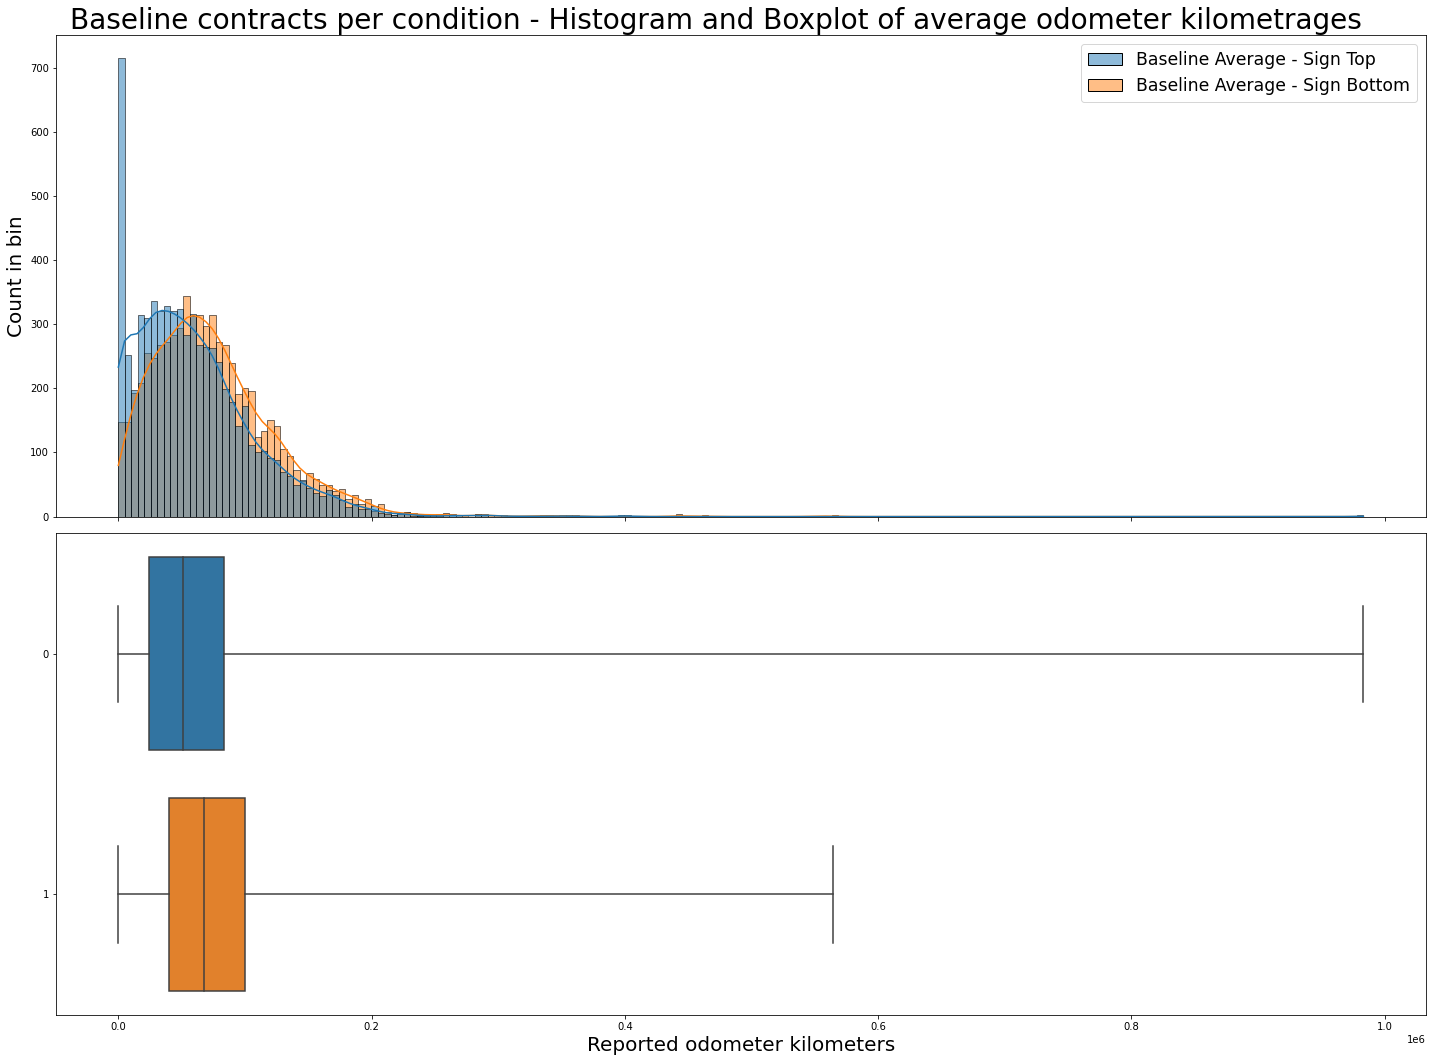

In [24]:
fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex="col")

fig.suptitle(f"Baseline contracts per condition - Histogram and Boxplot of average odometer kilometrages", fontsize=28)

sns.histplot({"Baseline Average - Sign Top":sign_top["baseline_average"],
              "Baseline Average - Sign Bottom": sign_bot["baseline_average"]}, kde=True, ax=axs[0])

sns.move_legend(axs[0], "upper right", fontsize="xx-large")

sns.boxplot(data=[sign_top["baseline_average"].to_numpy(), sign_bot["baseline_average"].to_numpy()],
            orient="h", ax=axs[1], whis=np.inf)
axs[0].set_ylabel("Count in bin", fontsize=20)
axs[1].set_xlabel("Reported odometer kilometers", fontsize=20)

fig.tight_layout()

The end of boxplot whiskers represents the minimum and maximum data point, while boxplots show quartiles of distributions.

#### 4.6. Test if there is significant difference between baseline documents

According to the arguments presented in subtask 4.3, here we will also use a two-sample t-test with a significance level ($\alpha$) of 0.001 to test the hypothesis. The dataset is divided according to the condition(sign bottom or sign top) on which the renewed contract is signed. For simplicity, we will continue to call them signed top and signed at the bottom, although all baseline documents are signed at the bottom.

##### Hypothesis:

\begin{equation}
H_0 = \text{Mean of average baseline kilometrage for bottom signed and top signed policies is same: } \mu_{\text{Sign bottom}} = \mu_{\text{Sign top}}
\\
H_a= \text{Mean of average baseline kilometrage for bottom signed and top signed policies is different: } \mu_{\text{Sign bottom}} \neq \mu_{\text{Sign top}}
\end{equation}




In [25]:
t_test_baseline_average = stats.ttest_ind(sign_bot["baseline_average"], sign_top["baseline_average"])

pd.DataFrame(data=[t_test_baseline_average.statistic, t_test_baseline_average.pvalue],
             columns=["Two-sample t-test"], index=["t statistic", "p-value"])

,Two-sample t-test
t statistic,1.775773e+01
p-value,9.333114e-70


There was a significant difference between means of baseline policies signed at the bottom (M=75020; SD=59696) and those who are signed at the top (M=50256; SD=49956), t(45448164) = 17.7758, p<<0.001. These results contradict the expected results set out in subtask 4.4., which is why we must conclude that the experiment was not conducted properly and the data is invalid.

## Interlude: Something is dodgy about this data...

---

Noticing the oddities in the data, you send an email to your contact at the insurance company asking about the integrity of the data. Their reply seems like something out of a detective movie:

> Dear researcher, I believe that this data is not to be trusted. I can't talk right now but will send further hints
>throughout the week.

As a researcher, you know that [data integrity](https://en.wikipedia.org/wiki/Data_integrity) is a big deal, and decide
 to investigate.

### Task 5 — 9pts

The first hint you receive is: *there is something off about the kilometrage values in the data.*

1. For the baseline contract and for the updated contract, plot the distribution of odometer kilometrage reported for
the first motorcycle insured in each policy.
2. For the first motorcycle insured by the company in each policy, plot the difference between the number of kilometers
 reported in the baseline and in the updated contract.
3. **Discuss:** why is this data unlikely to have originated from real odometer readings?

---

#### 5.1. Distribution of odometer kilometrage

Baseline odometer kilometers reports that equal 0 (for motorcycle1): [117 of 13486]
Updated odometer kilometers reports that equal 0 (for motorcycle1): [0 of 13486]


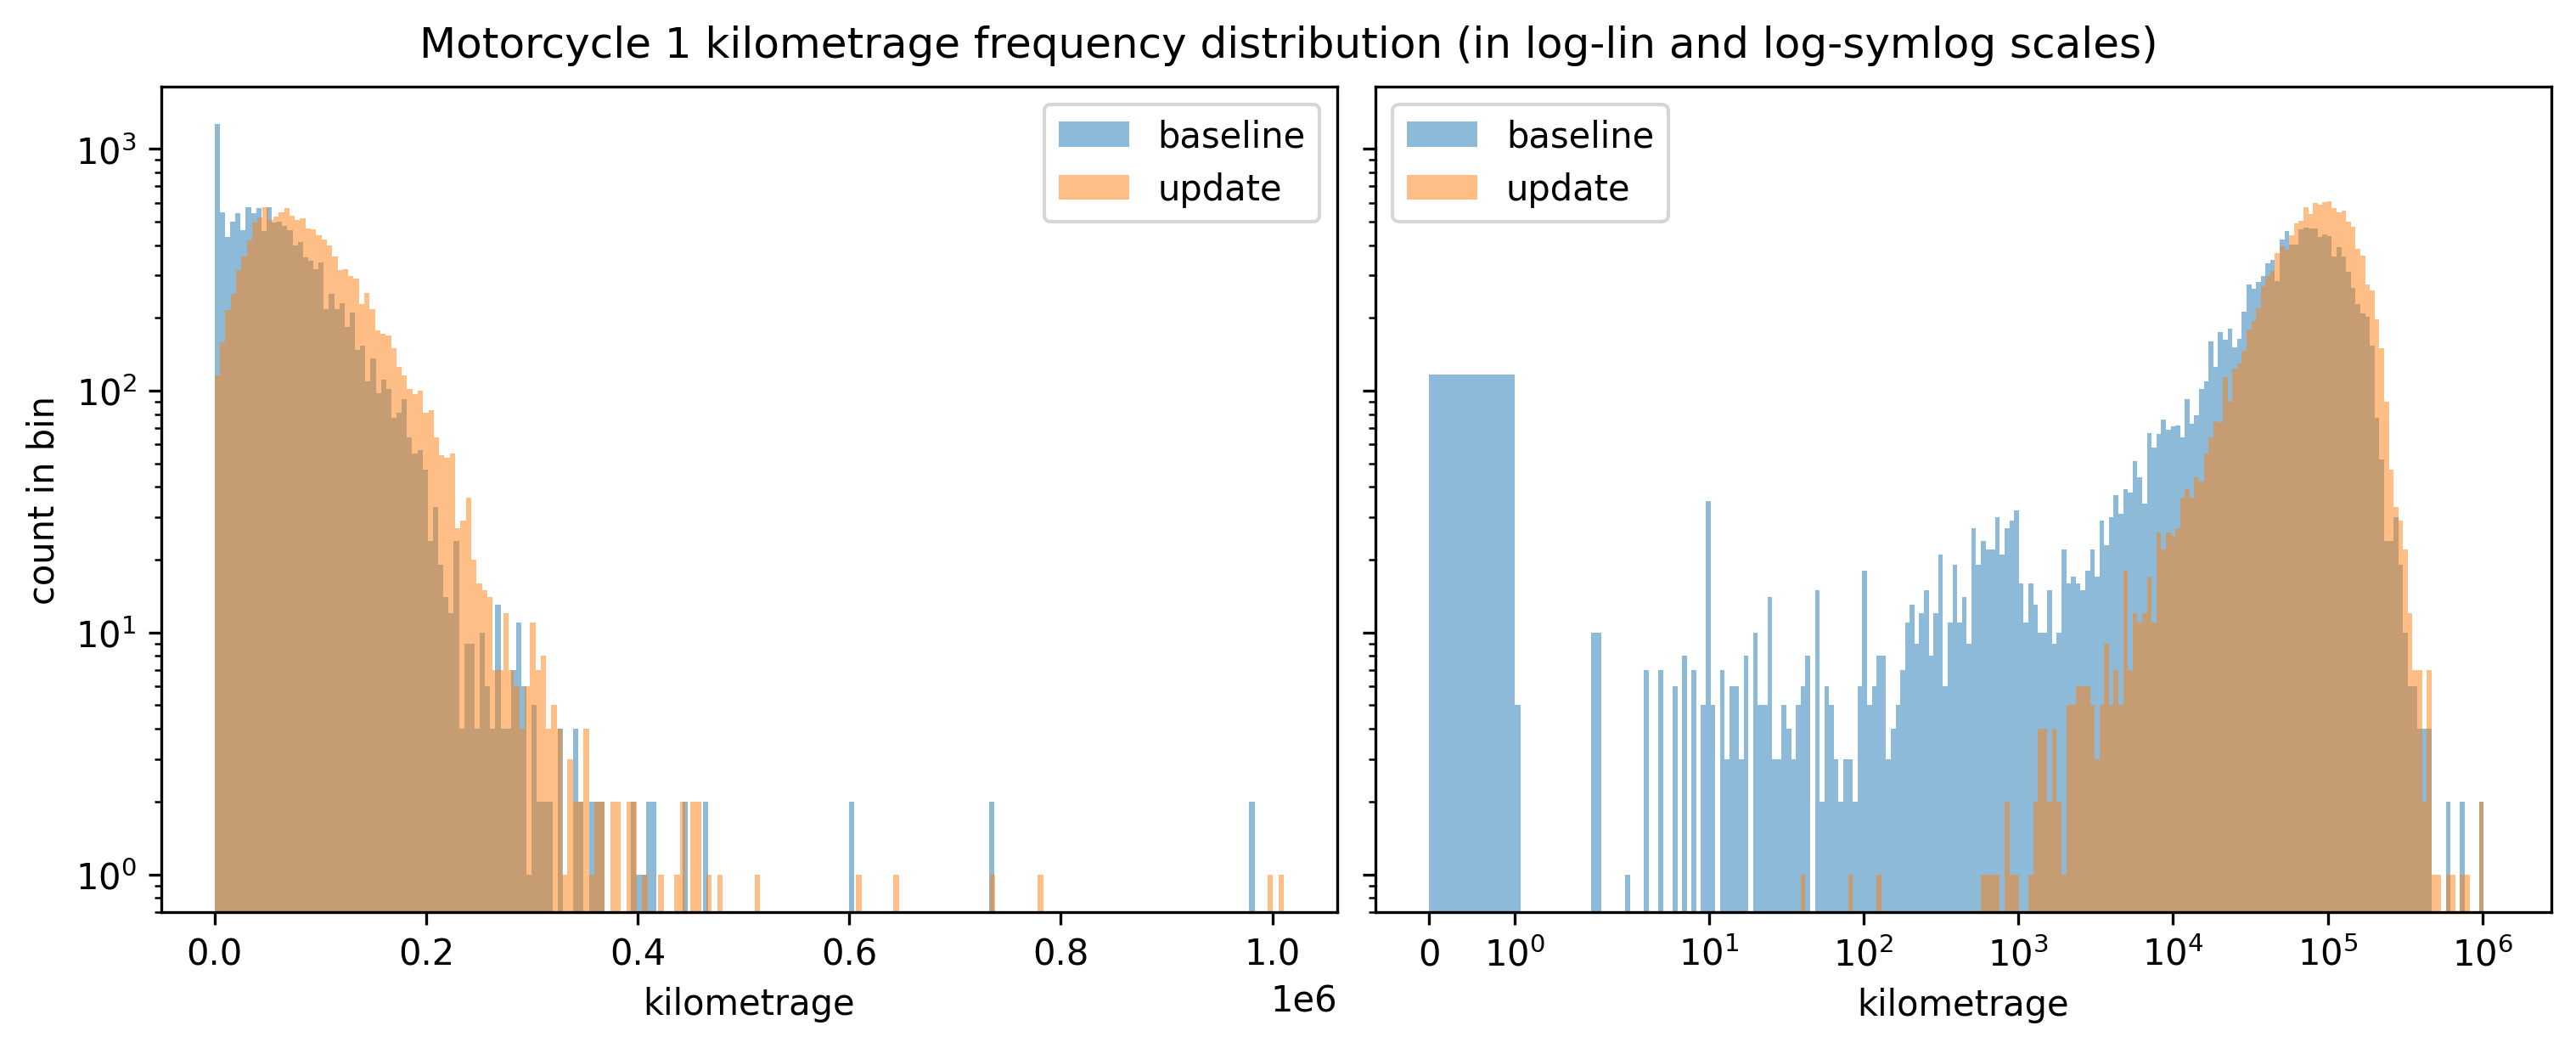

In [26]:
fig = plt.figure(dpi=300, figsize=(10, 4), constrained_layout=True)
fig.suptitle("Motorcycle 1 kilometrage frequency distribution (in log-lin and log-symlog scales)")
axs = fig.subplots(nrows=1, ncols=2, sharey=True)
axs[0].set_yscale("log")
axs[0].set_ylabel("count in bin")
axs[1].set_xscale("symlog")

bins_left = 200
bins_right = np.concatenate([np.array([0]), np.logspace(0, 6.1, 200)])
for i, bins in enumerate([bins_left, bins_right]):
    axs[i].hist(insurance_ds.baseline_motorcycle1, alpha=0.5, bins=bins, label="baseline")
    axs[i].hist(insurance_ds.update_motorcycle1, alpha=0.5, bins=bins, label="update")
    axs[i].set_xlabel("kilometrage")
    axs[i].legend(loc="best")

for name, column in [("Baseline", "baseline_motorcycle1"), ("Updated", "update_motorcycle1")]:
    total = insurance_ds.shape[0]
    zeros = insurance_ds.query(f'{column} == 0').shape[0]
    print(f"{name} odometer kilometers reports that equal 0 (for motorcycle1): [{zeros} of {total}]")

The graphs above show the same data in log-lin and right log-symlog histograms, the latter using symlog on x to see how many values are equal to zero, which would otherwise be missed by a log axis. We see that on both graphs the distributions of the reported baseline-update contract odometer kilometers differ.

The first noticeable difference is that the updated contract distribution (orange) is shifted left. The appearance of a shift is not surprising because we expect the updated kilometers to be higher, thus introducing some kind of shift to the right.

The second noteworthy difference in the distributions is that there are 117 baseline odometer readings out of 13486 that are equal to zero, compared to the updated reports where there are none. This is again not surprising because the older, baseline contracts could have been made when the motorcycles have been brand new. In fact, judging upon the fuzzy knowledge that [this forum](https://advrider.com/f/threads/new-bike-how-many-miles.1422010/) inherits, some new bikes seem to have a zero on their odometers.

#### 5.2. The difference between reported baseline and updated odometer kilometers

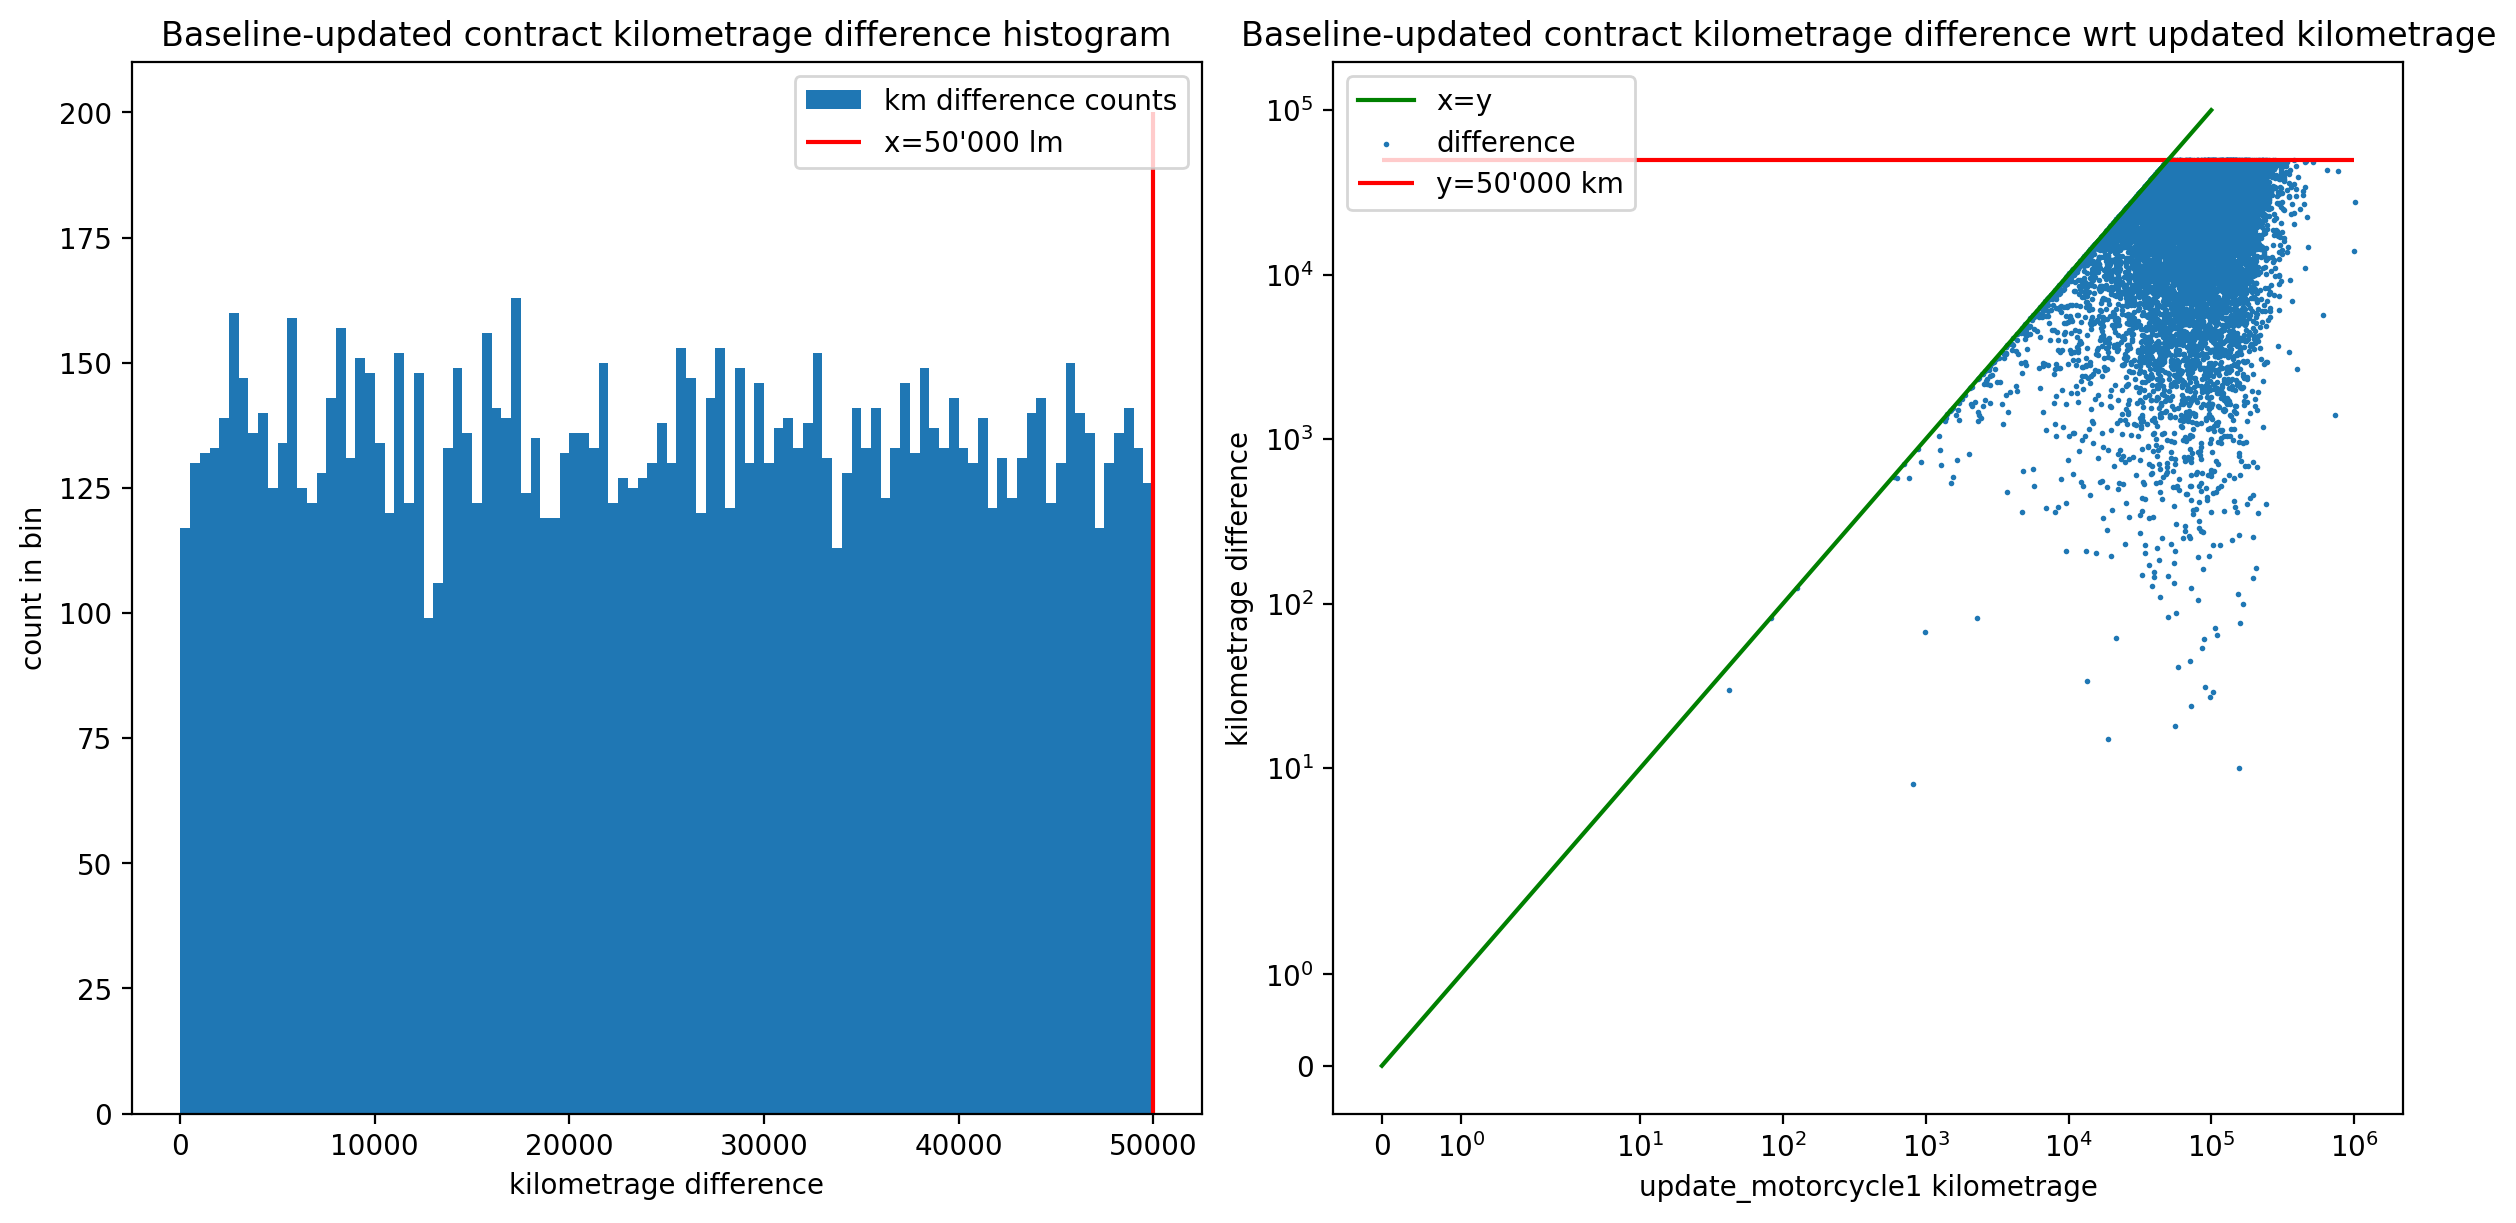

In [27]:
def plot_km_diff(update_kilometrage, baseline_kilometrage):
    km_diff = update_kilometrage - baseline_kilometrage
    # print(f"The top 100 largest kilometrage differences: {km_diff.sort_values(ascending=False).head(100).array}")

    fig = plt.figure(dpi=200, constrained_layout=True, figsize=(12, 6))
    axs = fig.subplots(nrows=1, ncols=2)

    # LEFT PLOT
    # bins = np.concatenate([np.array([0]), np.logspace(0, np.log10(50000), 200)])
    bins = 100
    axs[0].hist(km_diff, bins=bins, label="km difference counts")
    axs[0].vlines(50000, 0, 200, color="red", label="x=50'000 lm")

    axs[0].set_title("Baseline-updated contract kilometrage difference histogram")
    axs[0].set_xlabel("kilometrage difference")
    axs[0].set_ylabel("count in bin")
    axs[0].legend(loc="best")

    # RIGHT PLOT
    symlogspace = np.concatenate([np.array([0]), np.logspace(0, 5, 300)])
    axs[1].scatter(update_kilometrage, km_diff, label="difference", s=1)
    axs[1].plot(symlogspace, symlogspace, color="green", label="x=y")
    axs[1].hlines(50000, 0, 0.1 * 10 ** 7, color="red", label="y=50'000 km")

    axs[1].set_yscale("symlog")
    axs[1].set_xscale("symlog")
    axs[1].set_title("Baseline-updated contract kilometrage difference wrt updated kilometrage")
    axs[1].set_xlabel("update_motorcycle1 kilometrage")
    axs[1].set_ylabel("kilometrage difference")
    axs[1].legend(loc="best")

plot_km_diff(insurance_ds.update_motorcycle1, insurance_ds.baseline_motorcycle1)

In [28]:
print("Assume beforehand a p-value threshold of 5%")
print("KS test of kilometrage differences with Uniform(0,50000):")
km_diff = insurance_ds.update_motorcycle1 - insurance_ds.baseline_motorcycle1
stats.kstest(km_diff, 'uniform', args=(km_diff.min(), km_diff.max()))

Assume beforehand a p-value threshold of 5%
KS test of kilometrage differences with Uniform(0,50000):


KstestResult(statistic=0.0055227916967321156, pvalue=0.8030946430392445)

The left lin-lin graph shows a histogram of kilometrage differences as computed by $(update\_kilometrage - baseline\_kilometrage)$. In our data, the differences are strictly positive, which means that, in each updated contract, the customer has used his motorcycle to cross some distance. What is peculiar on this graph is that a uniform kilometrage difference distribution is a reasonable hypothesis we could not reject. The performed Kolmogorov-Smirnov test indicates strong evidence for the null hypothesis, giving a p-value of 0.803 (for a p-value threshold of 5%).

On the right symlog-symlog scatter plot, the kilometrage difference with respect to the reported updated kilometrage is denoted. We include this scatter plot to again highlight the abrupt cut-off point at 50'000 km, related to the evident uniform distribution that spans from 0 km to 50'000 km. No points cross the red line. Also, notice that the points self-evidently may not cross the green line in our dataset (which depicts the points where the kilometrage difference would be equal to the updated_kilometrage).

#### 5.3. Discussion: data unlikely from real odometer readings

As seen in the previous figure, there is strong evidence for the kilometrage differences to follow a uniform distribution. Combined with the corresponding observation that no insurance customer could make more than 50'000 km in the time between the two contracts, depicts a rather arbitrary than realistic scenario. The distribution of the differences of real odometer readings is not limited to reaching only $50000$, and it is counterintuitive that kilometrage differences would follow a uniform distribution as most natural phenomena like this one would follow a normal distribution. These observations make it reasonable to believe that the odometer readings have unlikely been made by a real odometer, confirming the doubts that this data should not be trusted as it seems not to have integrity. The uniform distribution could, in fact, be a product of vicious and naive data hand-crafting.

### Task 6 — 15pts

The second hint you receive is: *there is something off with the last digits of the reported kilometrages.*

1. Considering the baseline kilometrage of the first motorcycle in each contract (`baseline_motorcycle1`), plot the
distribution of occurrences of the last three digits. Repeat the same for the updated kilometrage of the first
motorcycle in each contract (`update_motorcycle1`).

3. **Discuss:** What are the differences between the two distributions?

4. **Discuss:** Hypothesize a **plausible** cause for the patterns observed in the digit distribution of the baseline
 kilometrage of the first motorcycle.

---

**Hint:** The last three digits of the number 12314 are 314. Note that you should consider the three last digits together,
 not separately!

#### 6.1. Last three digits distribution

Suppose a p-value threshold of 5% for the upcoming tests.
KS Test of Uniform(0,999) with baseline_motorcycle1 last-three-digits for Kilometrage \in [0,999]:
    KstestResult(statistic=0.34909435501852565, pvalue=1.9521139448274417e-92)


KS Test of Uniform(0,999) with baseline_motorcycle1 last-three-digits for Kilometrage >= 1000:
    KstestResult(statistic=0.10251827527575036, pvalue=3.936305449139337e-116)


KS Test of Uniform(0,999) with update_motorcycle1 last-three-digits for Kilometrage \in [0,999]:
    KstestResult(statistic=0.33087633087633095, pvalue=0.14192818031676158)


KS Test of Uniform(0,999) with update_motorcycle1 last-three-digits for Kilometrage >= 1000:
    KstestResult(statistic=0.004251449965735676, pvalue=0.9670881873149497)




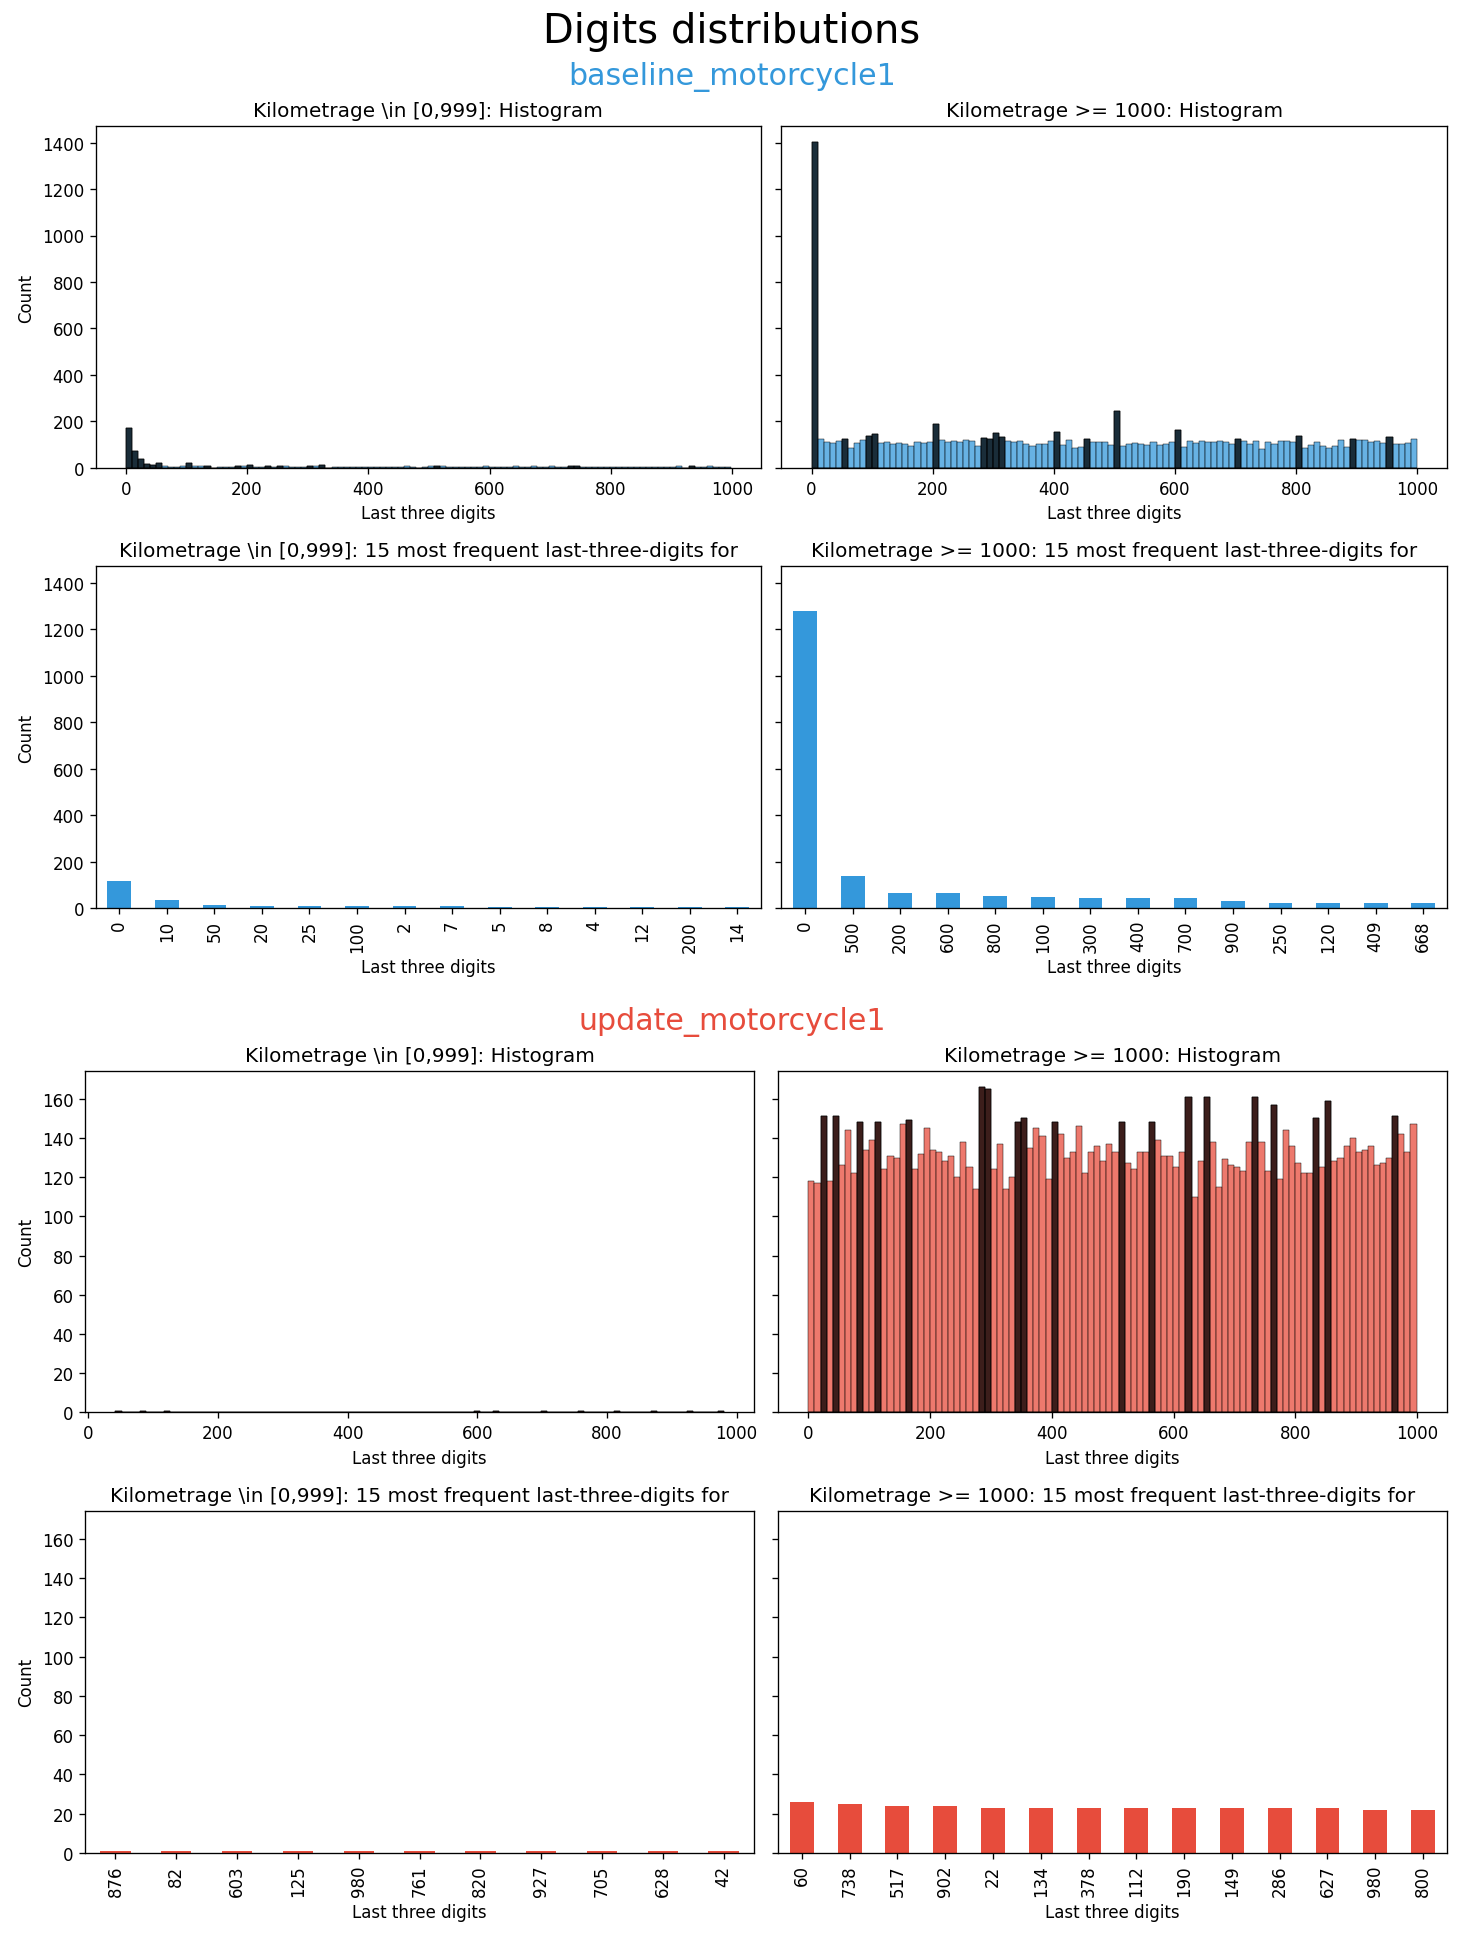

In [29]:
# i-will-bombard-you-with-numbers figures below

print("Suppose a p-value threshold of 5% for the upcoming tests.")


fig = plt.figure(constrained_layout=True, figsize=(12, 16), dpi=120)
fig.suptitle('Digits distributions', fontsize=24)

subfigures = fig.subfigures(nrows=2, ncols=1)
columns = ["baseline_motorcycle1", "update_motorcycle1"]
colors = ["#3498db", "#e74c3c"]
shared_axis = None
for column, color, subfig in zip(columns, colors, subfigures):
    subfig.suptitle(f'{column}', color=color, fontsize=18)
    axs = subfig.subplots(nrows=2, ncols=2, sharey=True)
    axs[0, 0].set_ylabel("Count")
    axs[1, 0].set_ylabel("Count")
    # axs[0].set_yscale("log")
    # if shared_axis is None:
    #     shared_axis = axs[0, 0]
    # else:
    #     axs[0, 0].get_shared_y_axes().join(shared_axis, axs[0, 0])

    below_1000km = insurance_ds[insurance_ds[column] < 1000][column]
    above_1000km = insurance_ds[insurance_ds[column] >= 1000][column].apply(lambda x: x % 1000)
    for i, (x, title) in enumerate(
            [(below_1000km, 'Kilometrage \in [0,999]'),
             (above_1000km, 'Kilometrage >= 1000')]):
        axs[0, i].set_xlabel("Last three digits")
        axs[0, i].set_title(f"{title}: Histogram")

        import warnings

        with warnings.catch_warnings():  # https://stackoverflow.com/questions/40659212/futurewarning-elementwise-comparison-failed-returning-scalar-but-in-the-futur
            warnings.simplefilter(action='ignore', category=FutureWarning)

            counts, bins = np.histogram(x, bins=100)
            sns.histplot(x=bins[:-1], bins=bins, weights=counts, color=color, ax=axs[0, i])

            highlight_counts = np.where(counts >= np.sort(counts)[-15:].min(), counts, 0)
            sns.histplot(x=bins[:-1], bins=bins, weights=highlight_counts, color="black", ax=axs[0, i])

        axs[1, i].set_title(f"{title}: 15 most frequent last-three-digits for")
        axs[1, i].set_xlabel("Last three digits")
        x.value_counts()[:14].plot.bar(ax=axs[1, i], color=color)

        ks_test_result = stats.kstest(x, 'uniform', args=(0,999))
        print(f"KS Test of Uniform(0,999) with {column} last-three-digits for {title}:"
              f"\n    {ks_test_result}\n\n")

#### 6.2. **Discussion**: Digit distribution differences

We have separated the distributions for $[0,999]$ and $[1000,+\infty)$ and thus can make observations aware of the fact about how many values were equal to $0$ compared to ending with $000$, etc. Also, below each histogram, we added a bar plot of 15 most frequent kilometrage last-three-digit values found for the given data. Based on the data, we make two observations.

Firstly, the $[0,999]$ interval had almost no datapoints for the updated contracts, whereas the baseline contracts had significantly more -- especially around 0. This is interesting because we can notice that many motorcycles have been reported to have around 0 odometer kilometrage. Otherwise, this difference is not interesting as it makes intuitive sense that updated contracts should not have many reports of such low odometer kilometrage (lower than 1000).

The second and more interesting observation is that the updated contracts contain a last-three-digits distributions that follow a uniform distribution in (0,999) with strong evidence, as tested with a Kolmogorov-Smirnov test. The same test for the baseline contracts rejects the uniform distribution null hypothesis. The baseline contracts, in fact, have idiosyncratic odometer reports that have a higher frequency for round figures last-three-digits like $100$, $200$, $300$, $500$, $600$ and especially for $000$ which gives the highest spike and is the most frequently occurring value.

#### 6.3. **Discussion**: Cause hypothesis for observed patterns

To explain the first observation -- that many baseline odometer kilometrages are around 0, we would hypothesize that many motorcycles in the first contract have been brand new and did not cover much of a distance yet, thus having an odometer kilometrage of zero or around 0.

For the second observation -- that the update distribution is evidently uniform and that the baseline distribution has significant spikes around round figures, we argue that the baseline numbers have not all been read of an odometer, as the odometer should not give significantly more round figures. We therefore hypothesize that some odometer readings have been rounded down by humans filling the insurance forms (or some other preprocessing step). And because these human-in-the-loop traces exist, we further hypothesize that the baseline reports come from real human reports and that the update reports could be fabricated to follow what at first seems to be a reasonable last-three-digits distribution.

### Task 7 — 15pts

The third (and last) hint you receive is: *there is something wrong with the fonts.*

Your anonymous source explains that the `.tsv` file sent to you was derived from an Excel sheet. There, some of the rows
 were written in the font *Helvetica* while others were written in the font *Arial*. Your anonymous source sends you a
 file with the relation between policy id and the font used in the respective row (`fonts.csv`), and tells you that the
  rows with *Helvetica* font were fabricated.

1. Load `fonts.csv` and merge the `font` column into your pandas dataframe.
2. Considering only the kilometrage of the first motorcycle in each policy, calculate the number of rows with the Arial
and the Helvetica font, respectively. Also, plot the distribution of baseline kilometers for rows with the Arial font
and for rows with the Helvetica font.
3. Similar to what was done in task 6. Plot the distribution of the last three digits for 1) the first motorcycle in
each baseline contract (`baseline_motorcycle1`); and 2) the first motorcycle in each updated contract
 (`update_motorcycle1`).
4. **Discuss:** Why do these analyses provide evidence that the rows with Helvetica font were fabricated?

---

#### 7.1

In [30]:
# import the fonts.csv and merge it to the database

fonts = pd.read_csv('./data/fonts.csv')
insurance_dataset_fonts = insurance_ds.merge(fonts, on='id')


#### 7.2

In [31]:
# Arial/Helvetica rows

arial_baseline = insurance_dataset_fonts[insurance_dataset_fonts['font'] == 'Arial'][['baseline_motorcycle1']]
helvetica_baseline = insurance_dataset_fonts[insurance_dataset_fonts['font'] == 'Helvetica'][['baseline_motorcycle1']]

pd.DataFrame([len(arial_baseline), len(helvetica_baseline)], columns=["Number of rows"],
             index=["Arial", "Helvetica"])


,Number of rows
Arial,6744
Helvetica,6742


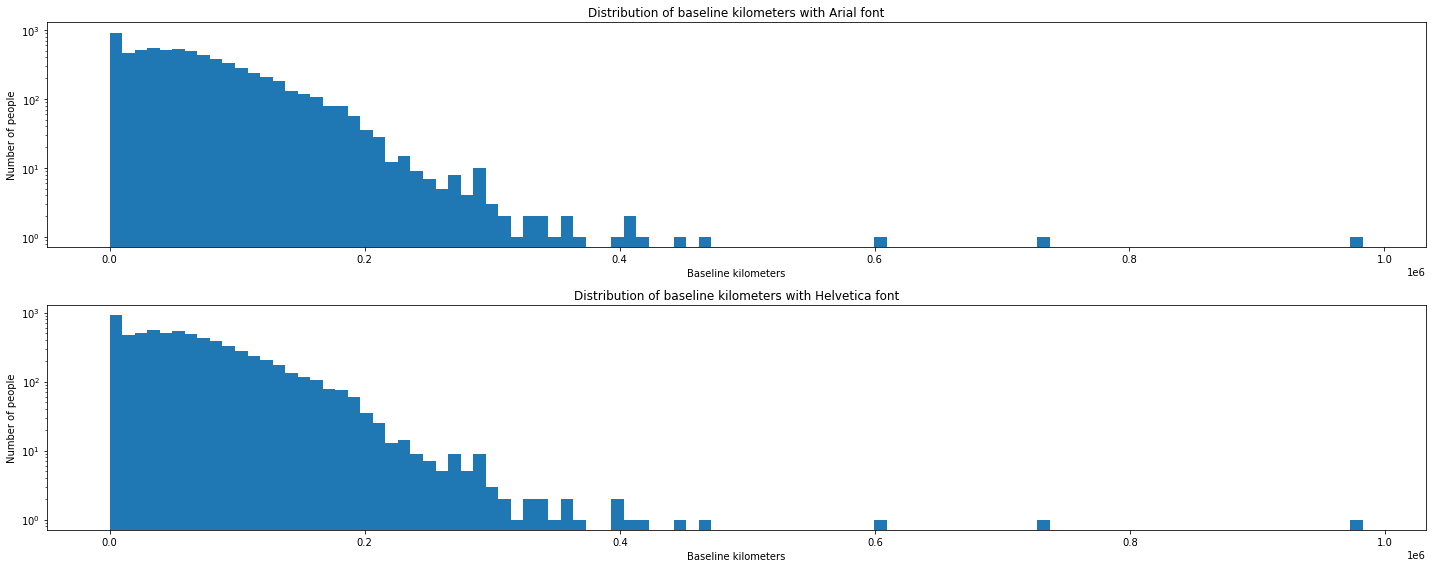

In [32]:

# Arial/Helvetica distributions

n_bins = 100
x1 = arial_baseline['baseline_motorcycle1']
x2 = helvetica_baseline['baseline_motorcycle1']

fig, axs = plt.subplots(2, 1, sharey=True, tight_layout=True, figsize=(20, 8))

axs[0].set_title('Distribution of baseline kilometers with Arial font')
axs[1].set_title('Distribution of baseline kilometers with Helvetica font')

axs[0].set_ylabel('Number of people')
axs[1].set_ylabel('Number of people')

axs[0].set_xlabel('Baseline kilometers')
axs[1].set_xlabel('Baseline kilometers')

axs[0].hist(x2, bins=n_bins)
axs[1].hist(x1, bins=n_bins)

axs[0].set_yscale("log")

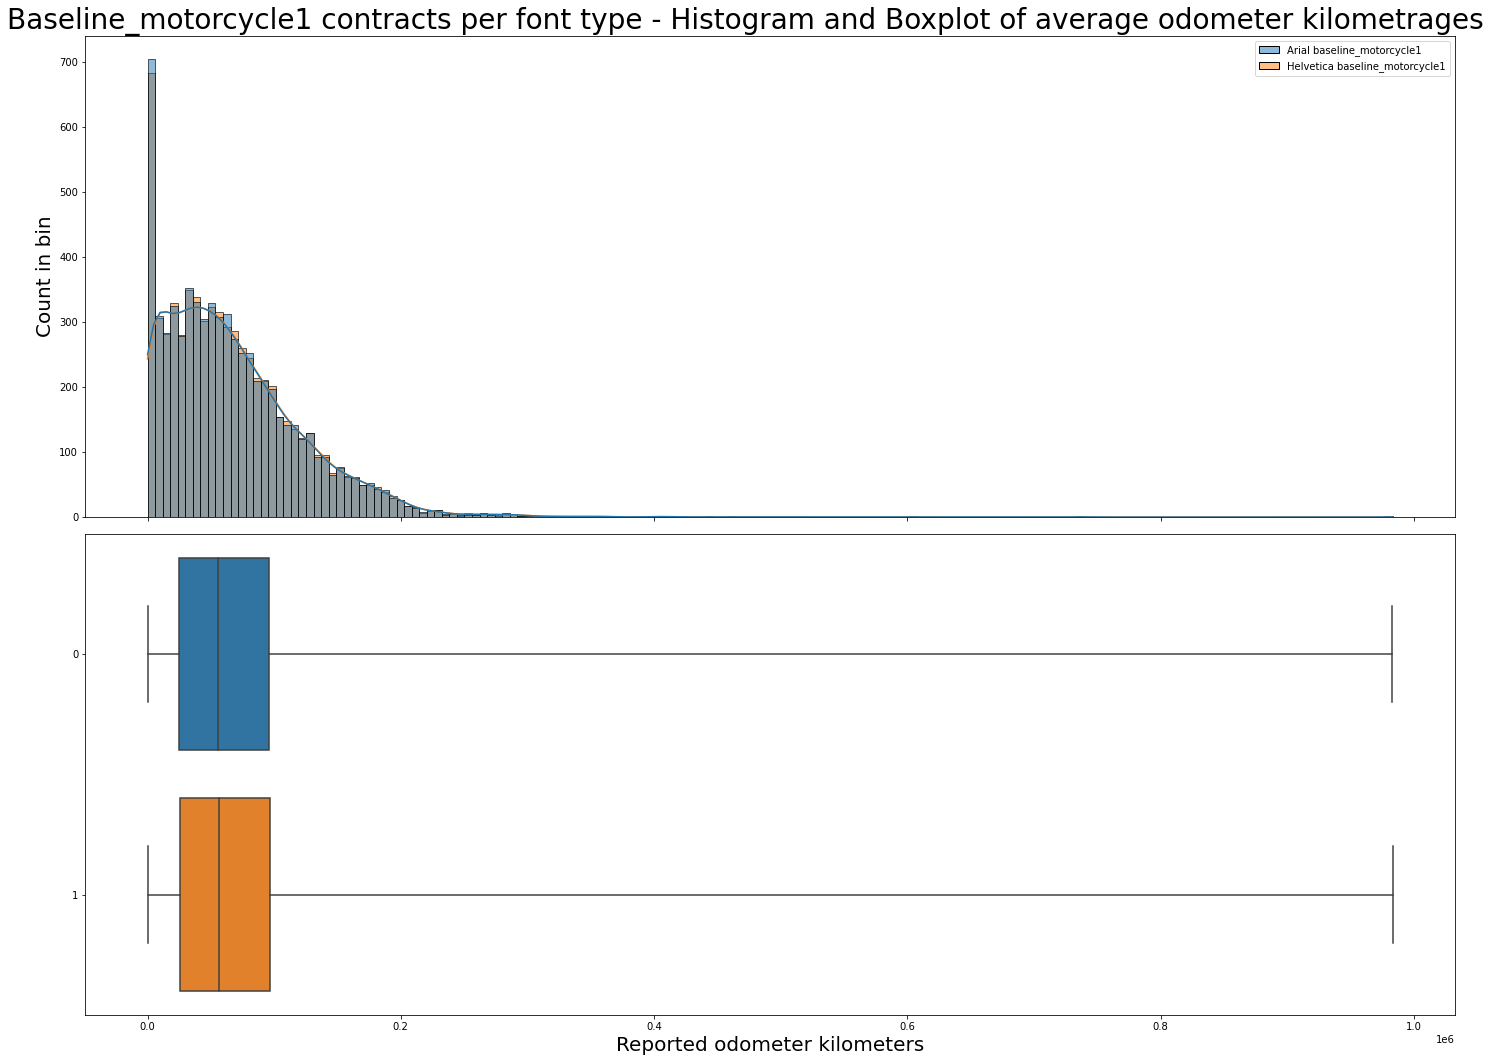

In [33]:
#compare the two distributions with plots

fig, axs = plt.subplots(2, 1, figsize=(20, 15), sharex="col")

fig.suptitle(f"Baseline_motorcycle1 contracts per font type - Histogram and Boxplot of average odometer kilometrages", fontsize=28)

sns.histplot(data={"Arial baseline_motorcycle1":x1,"Helvetica baseline_motorcycle1": x2}, kde=True, ax=axs[0])

sns.boxplot(data=[x1, x2], orient="h", ax=axs[1], whis=np.inf)

axs[0].set_ylabel("Count in bin", fontsize=20)
axs[1].set_xlabel("Reported odometer kilometers", fontsize=20)

fig.tight_layout()

The end of boxplot whiskers represents the minimum and maximum data point, while boxplots show quartiles of distributions.

In [34]:
#Kolmogorov-Smirnov test to see if these samples are from the same distribution
stats.ks_2samp(x1, x2)

KstestResult(statistic=0.04700113802994138, pvalue=6.502745452108272e-07)

As we can see from the plot as well, the test assures us that they are from the same distribution with a high probability.

#### 7.3

Assume beforehand a p-value threshold of 5%
KS tests with null hypothesis being the uniform(0,999) distribution:


1. Distribution of last 3 digits with Arial font (<1000 km) -- KS test:
KstestResult(statistic=0.6764264264264264, pvalue=1.3944209218884042e-201)

2. Distribution of last 3 digits with Arial font(>=1000 km) -- KS test:
KstestResult(statistic=0.20525096525096526, pvalue=3.2521741729636007e-233)

3. Distribution of last 3 digits with Helvetica font (<1000 km) -- KS test:
KstestResult(statistic=0.07349349349349349, pvalue=0.025229395836470214)

4. Distribution of last 3 digits with Helvetica font(>=1000 km) -- KS test:
KstestResult(statistic=0.007197831701142965, pvalue=0.8952183261433131)


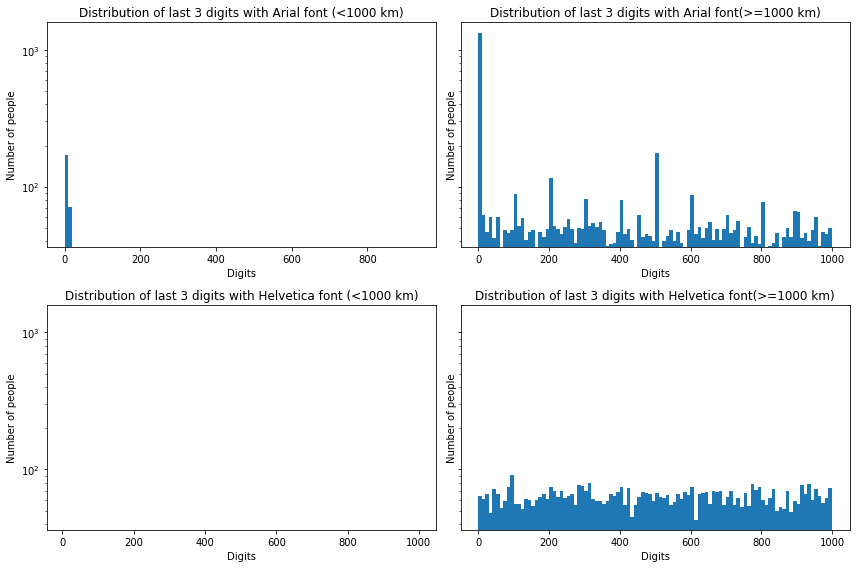

In [35]:
# last 3 digits distribution

arial_baseline_digits_s = arial_baseline[arial_baseline['baseline_motorcycle1'] < 1000]['baseline_motorcycle1']
helvetica_baseline_digits_s = helvetica_baseline[helvetica_baseline['baseline_motorcycle1'] < 1000][
    'baseline_motorcycle1']

arial_baseline_digits_l = arial_baseline[arial_baseline['baseline_motorcycle1'] >= 1000]['baseline_motorcycle1'].apply(
    lambda x: int(str(x)[-3:]))
helvetica_baseline_digits_l = helvetica_baseline[helvetica_baseline['baseline_motorcycle1'] >= 1000][
    'baseline_motorcycle1'].apply(lambda x: int(str(x)[-3:]))

fig, axs = plt.subplots(2, 2, sharey=True, tight_layout=True, figsize=(12, 8))

axs[0, 0].set_title('Distribution of last 3 digits with Arial font (<1000 km)')
axs[1, 0].set_title('Distribution of last 3 digits with Helvetica font (<1000 km)')
axs[0, 1].set_title('Distribution of last 3 digits with Arial font(>=1000 km)')
axs[1, 1].set_title('Distribution of last 3 digits with Helvetica font(>=1000 km)')

axs[0, 0].set_ylabel('Number of people')
axs[1, 0].set_ylabel('Number of people')
axs[0, 1].set_ylabel('Number of people')
axs[1, 1].set_ylabel('Number of people')

axs[0, 0].set_xlabel('Digits')
axs[1, 0].set_xlabel('Digits')
axs[0, 1].set_xlabel('Digits')
axs[1, 1].set_xlabel('Digits')

n_bins = 100

axs[0, 0].hist(arial_baseline_digits_s, bins=n_bins)
axs[1, 0].hist(helvetica_baseline_digits_s, bins=n_bins)
axs[0, 1].hist(arial_baseline_digits_l, bins=n_bins)
axs[1, 1].hist(helvetica_baseline_digits_l, bins=n_bins)

axs[0, 0].set_yscale("log")

print("Assume beforehand a p-value threshold of 5%")
print("KS tests with null hypothesis being the uniform(0,999) distribution:")
print('\n\n1. Distribution of last 3 digits with Arial font (<1000 km) -- KS test:')
print(stats.kstest(arial_baseline_digits_s, "uniform", args=(0,999)))

print('\n2. Distribution of last 3 digits with Arial font(>=1000 km) -- KS test:')
print(stats.kstest(arial_baseline_digits_l, "uniform", args=(0,999)))

print('\n3. Distribution of last 3 digits with Helvetica font (<1000 km) -- KS test:')
print(stats.kstest(helvetica_baseline_digits_s, "uniform", args=(0,999)))

print('\n4. Distribution of last 3 digits with Helvetica font(>=1000 km) -- KS test:')
print(stats.kstest(helvetica_baseline_digits_l, "uniform", args=(0,999)))

#### 7.4
In task 6, we discussed how we could see a tendency of rounding the kilometers in baseline contracts, attributing it to humans being involved in the loop, and there was a lot of data around 0 that was likely due to the new motorcycles. As for the last 3 digits originating from the contracts with `Arial` font, we can observe the same oddities. However, the contracts with `Helvetica` font do not show these human-made patterns, but follow a uniform distribution with strong evidence (for values >= 1000 km). This serves as evidence for the claim that the `Helvetica` font entries have been fabricated.

On the other hand, the devil's advocate reminds us that a uniform distribution seems to be a more realistic distribution for odometer readings, so one might hypothesize as well that the observed pattern of rounding figures is a sign of fabrication -- maybe someone naive wrote the round figures themselves into the table, not knowing that someone would analyse the differences. This gives a case for the `Arial` font entries to be fabricated rather than the `Helvetica` ones. However, we do not lean towards these propositions as we have a strong signal from our anonymous information source for the `Helvetica` entries to be the fabricated ones (if the source is to be trusted).

### Task 8 — 15pts

You've had enough! You decide to write an email to your PI (principal investigator, also known as "your boss") reporting
 the oddities you have observed in the data. Write a (brief) text (in markdown) of up to 300 words. Your text should:

- Use the analyses you did to make a convincing case that the data has been tampered with.
- Grounded in your analyses, provide a plausible hypothesis about how the data has been tampered with.
- Discuss whether the data leads to the conclusion that signing at the top decreases dishonesty.

Structure your text into three bullets, analogous to the ones above.

You can reference images present in the notebook by indicating a task (e.g., image plotted in Task 3.3) or a cell
number.

Note that you do not need to conduct any additional analysis to write this text. If you do, the code should be at the
end of this notebook, i.e., after your answer.

---

**Hint:** The data has been tampered with in more than one way.

---

Dear boss,

After analysing the provided data, we inform you that, although there is evidence for signing at the top **increasing** dishonesty, the data has been tampered with and any conclusions based on it cannot be trusted! We explain this in the following two points.

First, the data consists of disjoint subsets of Helvetica and Arial font policies that show a significant difference in their last-three-digits distributions of baseline contracts -- Arial following one that encodes human-mark patterns, and Helvetica a uniform one (7.4). In fact, all update contracts follow Helvetica's seemingly fabricated uniform distribution (6.3). To further spice things up, the kilometrage differences between update and baseline contracts follow a uniform distribution, having a sudden cut-off at 50'000km (5.3). Best for last, there is a significant difference between baseline kilometrages signed at top compared to ones signed at the bottom (4.6). This shouldn't be the case if each customer received a form randomly, and like previous remarks, it foretells data-forging.

Secondly, backed up with the described evidence, we have a strong hypothesis that this data is the work of evil sorcery! The story goes as follows. The Arial baseline contracts are the only real data. Based on its estimated kilometrage distribution, Helvetica baseline contracts have been fabricated to enlarge the data without taking care of the distribution of last-three-digits. Then, update contracts have been invented by adding a random number from (0,50000km) to the baseline values, leaving them tied together. Fabricating the top/bottom data next, the vicious scientist selected the update contracts with higher kilometrage values on average, thereby naively affecting the baseline contracts as well.

With the strong evidence laid out and a hypothesis that explains it, we warn that no conclusions made on this data should be trusted.

Hope somebody gets fired,
<br />
Best regards,
<br />
HiveMind team